In [1]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import tensorflow as tf
import numpy as np
import PIL
import ray
import io, json, os, math
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.expanduser('~/my_models')
os.makedirs(MODEL_PATH, exist_ok=True)

TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

print('슝=3')
print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(ray.__version__)

슝=3
2.6.0
1.21.4
8.3.2
1.7.0


0 - 오른쪽 발목
1 - 오른쪽 무릎
2 - 오른쪽 엉덩이
3 - 왼쪽 엉덩이
4 - 왼쪽 무릎
5 - 왼쪽 발목
6 - 골반
7 - 가슴(흉부)
8 - 목
9 - 머리 위
10 - 오른쪽 손목
11 - 오른쪽 팔꿈치
12 - 오른쪽 어깨
13 - 왼쪽 어깨
14 - 왼쪽 팔꿈치
15 - 왼쪽 손목

# 데이터 전처리하기

In [2]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

# 함수 테스트
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


- TFRecord 파일 만들기

In [3]:
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

print('슝=3')

슝=3


In [4]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

print('슝=3')

슝=3


In [5]:
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

- Ray

In [6]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

print('슝=3')

슝=3


In [7]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2025-05-29 02:10:15,685	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=5.46gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

(build_single_tfrecord pid=457) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0026_of_0064.tfrecords
(build_single_tfrecord pid=457) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=455) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0025_of_0064.tfrecords
(build_single_tfrecord pid=455) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0030_of_0064.tfrecords
(build_single_tfrecord pid=454) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0027_of_0064.tfrecords
(build_single_tfrecord pid=454) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0031_of_0064.tfrecords
(build_single_tfrecord pid=456) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=456) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_003

(build_single_tfrecord pid=456) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0055_of_0064.tfrecords
(build_single_tfrecord pid=456) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0059_of_0064.tfrecords
(build_single_tfrecord pid=455) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=455) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0061_of_0064.tfrecords
(build_single_tfrecord pid=457) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0056_of_0064.tfrecords
(build_single_tfrecord pid=457) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0060_of_0064.tfrecords
(build_single_tfrecord pid=454) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=454) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_006

- data label

In [8]:
def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

def crop_roi(image, features, margin=0.2):
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # keypoint 중 유효한값(visible = 1) 만 사용합니다.
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # min, max 값을 찾습니다.
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y

def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps

print('슝=3')

슝=3


In [2]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

print('슝=3')

슝=3


# Hourglass 모델 만들기
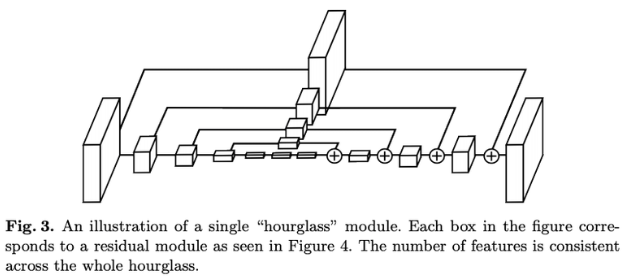
- 직육면체 박스는 residual block
- residual block 의 2가지 타입 : 3x3-3x3 basic block, 1x1-3x3-1x1 bottleneck block

In [ ]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

In [11]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

print('슝=3')

슝=3


- 학습엔진 만들기

In [4]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        labels = tf.cast(labels, tf.float32)
        loss = 0
        if not isinstance(outputs, list):
            outputs = [outputs] 
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

print('슝=3')

슝=3


In [5]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

print('슝=3')

슝=3


In [13]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

print('슝=3')

슝=3
(build_single_tfrecord pid=457) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/val_0008_of_0008.tfrecords


In [14]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 3
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)







INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 2.40172076 epoch total loss 2.40172076
Trained batch 2 batch loss 2.55860138 epoch total loss 2.48016119
Trained batch 3 batch loss 2.5012908 epoch total loss 2.48720431
Trained batch 4 batch loss 2.45836306 epoch total loss 2.47999406
Trained batch 5 batch loss 2.4343636 epoch total loss 2.47086787
Trained batch 6 batch loss 2.37172699 epoch total loss 2.45434451
Trained batch 7 batch loss 2.26608801 epoch total loss 2.42745066
Trained batch 8 batch loss 2.26944423 epoch total loss 2.40769982
Trained batch 9 batch loss 2.18630505 epoch total loss 2.38310027
Trained batch 10 batch loss 2.17675924 epoch total loss 2.36246634
Trained batch 11 batch loss 2.20932317 epoch total loss 2.34854412
Trained batch 12 batch loss 1.99604273 epoch total loss 2.31916904
Trained batch 13 batch loss 2.08947587 epoch total loss 2.30150032
Trained batch 14 batch loss 2.01831675 epoch total loss 2.28127289
Trained batch 15 batch loss 1.86571455 epo

Trained batch 124 batch loss 1.60010636 epoch total loss 1.80554724
Trained batch 125 batch loss 1.65717113 epoch total loss 1.80436027
Trained batch 126 batch loss 1.61085534 epoch total loss 1.8028245
Trained batch 127 batch loss 1.74140465 epoch total loss 1.80234087
Trained batch 128 batch loss 1.73270452 epoch total loss 1.80179691
Trained batch 129 batch loss 1.7414515 epoch total loss 1.80132914
Trained batch 130 batch loss 1.65532458 epoch total loss 1.80020595
Trained batch 131 batch loss 1.63164067 epoch total loss 1.7989192
Trained batch 132 batch loss 1.77694201 epoch total loss 1.79875278
Trained batch 133 batch loss 1.60818172 epoch total loss 1.79731989
Trained batch 134 batch loss 1.71159649 epoch total loss 1.79668021
Trained batch 135 batch loss 1.47222841 epoch total loss 1.79427683
Trained batch 136 batch loss 1.54667175 epoch total loss 1.79245627
Trained batch 137 batch loss 1.58442688 epoch total loss 1.79093778
Trained batch 138 batch loss 1.75280929 epoch total

Trained batch 246 batch loss 1.66359448 epoch total loss 1.72405195
Trained batch 247 batch loss 1.60898805 epoch total loss 1.72358608
Trained batch 248 batch loss 1.49006248 epoch total loss 1.72264445
Trained batch 249 batch loss 1.58825493 epoch total loss 1.72210467
Trained batch 250 batch loss 1.65169895 epoch total loss 1.7218231
Trained batch 251 batch loss 1.66128922 epoch total loss 1.72158194
Trained batch 252 batch loss 1.56281924 epoch total loss 1.72095191
Trained batch 253 batch loss 1.53233671 epoch total loss 1.72020638
Trained batch 254 batch loss 1.60713613 epoch total loss 1.71976125
Trained batch 255 batch loss 1.65171885 epoch total loss 1.71949446
Trained batch 256 batch loss 1.63109791 epoch total loss 1.71914923
Trained batch 257 batch loss 1.57523477 epoch total loss 1.71858919
Trained batch 258 batch loss 1.57837284 epoch total loss 1.71804571
Trained batch 259 batch loss 1.59016442 epoch total loss 1.71755207
Trained batch 260 batch loss 1.68324089 epoch tot

Trained batch 367 batch loss 1.51029336 epoch total loss 1.68477166
Trained batch 368 batch loss 1.46264553 epoch total loss 1.6841681
Trained batch 369 batch loss 1.49948263 epoch total loss 1.68366766
Trained batch 370 batch loss 1.59978271 epoch total loss 1.68344104
Trained batch 371 batch loss 1.60366905 epoch total loss 1.68322611
Trained batch 372 batch loss 1.6062361 epoch total loss 1.68301916
Trained batch 373 batch loss 1.6146611 epoch total loss 1.68283594
Trained batch 374 batch loss 1.61078024 epoch total loss 1.68264329
Trained batch 375 batch loss 1.64403617 epoch total loss 1.68254042
Trained batch 376 batch loss 1.65079033 epoch total loss 1.68245602
Trained batch 377 batch loss 1.6154753 epoch total loss 1.68227839
Trained batch 378 batch loss 1.61893392 epoch total loss 1.68211079
Trained batch 379 batch loss 1.64299297 epoch total loss 1.68200767
Trained batch 380 batch loss 1.55998337 epoch total loss 1.68168652
Trained batch 381 batch loss 1.69004011 epoch total 

Trained batch 488 batch loss 1.60601592 epoch total loss 1.66016364
Trained batch 489 batch loss 1.59286714 epoch total loss 1.66002607
Trained batch 490 batch loss 1.60766864 epoch total loss 1.65991926
Trained batch 491 batch loss 1.65883803 epoch total loss 1.659917
Trained batch 492 batch loss 1.60289359 epoch total loss 1.65980113
Trained batch 493 batch loss 1.61907375 epoch total loss 1.65971851
Trained batch 494 batch loss 1.60942852 epoch total loss 1.65961671
Trained batch 495 batch loss 1.52063692 epoch total loss 1.65933597
Trained batch 496 batch loss 1.56358099 epoch total loss 1.65914285
Trained batch 497 batch loss 1.51297367 epoch total loss 1.65884888
Trained batch 498 batch loss 1.42543221 epoch total loss 1.65838015
Trained batch 499 batch loss 1.57399583 epoch total loss 1.65821099
Trained batch 500 batch loss 1.594239 epoch total loss 1.65808296
Trained batch 501 batch loss 1.55344176 epoch total loss 1.65787423
Trained batch 502 batch loss 1.46082 epoch total los

Trained batch 609 batch loss 1.58182859 epoch total loss 1.63581371
Trained batch 610 batch loss 1.71493661 epoch total loss 1.63594353
Trained batch 611 batch loss 1.56138802 epoch total loss 1.63582146
Trained batch 612 batch loss 1.67751622 epoch total loss 1.63588953
Trained batch 613 batch loss 1.67983437 epoch total loss 1.63596129
Trained batch 614 batch loss 1.50648296 epoch total loss 1.63575029
Trained batch 615 batch loss 1.51571536 epoch total loss 1.63555515
Trained batch 616 batch loss 1.46781409 epoch total loss 1.63528287
Trained batch 617 batch loss 1.27613723 epoch total loss 1.63470078
Trained batch 618 batch loss 1.40531194 epoch total loss 1.63432956
Trained batch 619 batch loss 1.41962 epoch total loss 1.63398278
Trained batch 620 batch loss 1.28750086 epoch total loss 1.63342381
Trained batch 621 batch loss 1.32535195 epoch total loss 1.63292778
Trained batch 622 batch loss 1.29363477 epoch total loss 1.63238227
Trained batch 623 batch loss 1.39630735 epoch total

Trained batch 730 batch loss 1.48779678 epoch total loss 1.61832857
Trained batch 731 batch loss 1.60089564 epoch total loss 1.61830485
Trained batch 732 batch loss 1.52087927 epoch total loss 1.61817169
Trained batch 733 batch loss 1.71649384 epoch total loss 1.61830592
Trained batch 734 batch loss 1.4851253 epoch total loss 1.61812449
Trained batch 735 batch loss 1.56971645 epoch total loss 1.61805856
Trained batch 736 batch loss 1.50025547 epoch total loss 1.61789858
Trained batch 737 batch loss 1.47676659 epoch total loss 1.61770713
Trained batch 738 batch loss 1.50692844 epoch total loss 1.61755705
Trained batch 739 batch loss 1.48736084 epoch total loss 1.61738074
Trained batch 740 batch loss 1.39882123 epoch total loss 1.61708534
Trained batch 741 batch loss 1.35875463 epoch total loss 1.61673677
Trained batch 742 batch loss 1.41686821 epoch total loss 1.61646748
Trained batch 743 batch loss 1.45946288 epoch total loss 1.61625612
Trained batch 744 batch loss 1.41244078 epoch tot

Trained batch 851 batch loss 1.57531857 epoch total loss 1.60374129
Trained batch 852 batch loss 1.4938854 epoch total loss 1.6036123
Trained batch 853 batch loss 1.49862099 epoch total loss 1.60348928
Trained batch 854 batch loss 1.49559665 epoch total loss 1.60336292
Trained batch 855 batch loss 1.50418007 epoch total loss 1.60324693
Trained batch 856 batch loss 1.36909962 epoch total loss 1.60297346
Trained batch 857 batch loss 1.55830741 epoch total loss 1.60292137
Trained batch 858 batch loss 1.55927038 epoch total loss 1.60287058
Trained batch 859 batch loss 1.49502611 epoch total loss 1.60274494
Trained batch 860 batch loss 1.473364 epoch total loss 1.60259461
Trained batch 861 batch loss 1.56335366 epoch total loss 1.60254896
Trained batch 862 batch loss 1.49355328 epoch total loss 1.60242248
Trained batch 863 batch loss 1.39565635 epoch total loss 1.60218287
Trained batch 864 batch loss 1.51598179 epoch total loss 1.60208309
Trained batch 865 batch loss 1.44461489 epoch total 

Trained batch 973 batch loss 1.56020641 epoch total loss 1.58890152
Trained batch 974 batch loss 1.39549541 epoch total loss 1.58870304
Trained batch 975 batch loss 1.40806091 epoch total loss 1.58851779
Trained batch 976 batch loss 1.41923475 epoch total loss 1.58834422
Trained batch 977 batch loss 1.53487444 epoch total loss 1.58828962
Trained batch 978 batch loss 1.39178848 epoch total loss 1.58808875
Trained batch 979 batch loss 1.52817917 epoch total loss 1.58802748
Trained batch 980 batch loss 1.38512015 epoch total loss 1.58782053
Trained batch 981 batch loss 1.45878458 epoch total loss 1.58768892
Trained batch 982 batch loss 1.42162263 epoch total loss 1.58751976
Trained batch 983 batch loss 1.48555684 epoch total loss 1.58741617
Trained batch 984 batch loss 1.54332423 epoch total loss 1.58737135
Trained batch 985 batch loss 1.5147649 epoch total loss 1.58729768
Trained batch 986 batch loss 1.46847212 epoch total loss 1.58717716
Trained batch 987 batch loss 1.49375772 epoch tot

Trained batch 1093 batch loss 1.4607805 epoch total loss 1.57789588
Trained batch 1094 batch loss 1.41112947 epoch total loss 1.57774353
Trained batch 1095 batch loss 1.45678008 epoch total loss 1.57763302
Trained batch 1096 batch loss 1.44051433 epoch total loss 1.57750797
Trained batch 1097 batch loss 1.37360501 epoch total loss 1.57732213
Trained batch 1098 batch loss 1.5851264 epoch total loss 1.57732916
Trained batch 1099 batch loss 1.55478823 epoch total loss 1.57730877
Trained batch 1100 batch loss 1.57089603 epoch total loss 1.57730293
Trained batch 1101 batch loss 1.52980542 epoch total loss 1.57725978
Trained batch 1102 batch loss 1.72357726 epoch total loss 1.57739258
Trained batch 1103 batch loss 1.58616042 epoch total loss 1.57740057
Trained batch 1104 batch loss 1.61787903 epoch total loss 1.57743728
Trained batch 1105 batch loss 1.49279594 epoch total loss 1.57736063
Trained batch 1106 batch loss 1.4570663 epoch total loss 1.57725191
Trained batch 1107 batch loss 1.54135

Trained batch 1213 batch loss 1.47596598 epoch total loss 1.56683981
Trained batch 1214 batch loss 1.45734143 epoch total loss 1.56674969
Trained batch 1215 batch loss 1.4750073 epoch total loss 1.56667411
Trained batch 1216 batch loss 1.43083024 epoch total loss 1.56656229
Trained batch 1217 batch loss 1.40642023 epoch total loss 1.56643069
Trained batch 1218 batch loss 1.35688603 epoch total loss 1.56625867
Trained batch 1219 batch loss 1.46573949 epoch total loss 1.56617618
Trained batch 1220 batch loss 1.38044834 epoch total loss 1.56602407
Trained batch 1221 batch loss 1.51869941 epoch total loss 1.5659852
Trained batch 1222 batch loss 1.55524278 epoch total loss 1.5659765
Trained batch 1223 batch loss 1.43435466 epoch total loss 1.56586885
Trained batch 1224 batch loss 1.43769109 epoch total loss 1.56576419
Trained batch 1225 batch loss 1.43117607 epoch total loss 1.56565428
Trained batch 1226 batch loss 1.44058275 epoch total loss 1.56555223
Trained batch 1227 batch loss 1.38295

Trained batch 1333 batch loss 1.38404942 epoch total loss 1.55719483
Trained batch 1334 batch loss 1.28283072 epoch total loss 1.55698907
Trained batch 1335 batch loss 1.27655339 epoch total loss 1.55677903
Trained batch 1336 batch loss 1.32108986 epoch total loss 1.5566026
Trained batch 1337 batch loss 1.4214375 epoch total loss 1.55650151
Trained batch 1338 batch loss 1.39383101 epoch total loss 1.55637991
Trained batch 1339 batch loss 1.38490224 epoch total loss 1.55625188
Trained batch 1340 batch loss 1.45276594 epoch total loss 1.55617476
Trained batch 1341 batch loss 1.55927026 epoch total loss 1.55617714
Trained batch 1342 batch loss 1.50237691 epoch total loss 1.55613708
Trained batch 1343 batch loss 1.50290215 epoch total loss 1.55609739
Trained batch 1344 batch loss 1.47228992 epoch total loss 1.55603504
Trained batch 1345 batch loss 1.53211021 epoch total loss 1.55601728
Trained batch 1346 batch loss 1.3443048 epoch total loss 1.55585992
Trained batch 1347 batch loss 1.45316

Validated batch 107 batch loss 1.46126366
Validated batch 108 batch loss 1.43437517
Validated batch 109 batch loss 1.4483372
Validated batch 110 batch loss 1.33260906
Validated batch 111 batch loss 1.38063884
Validated batch 112 batch loss 1.44750023
Validated batch 113 batch loss 1.34354782
Validated batch 114 batch loss 1.44601226
Validated batch 115 batch loss 1.44034076
Validated batch 116 batch loss 1.4668901
Validated batch 117 batch loss 1.50202584
Validated batch 118 batch loss 1.45792377
Validated batch 119 batch loss 1.28244591
Validated batch 120 batch loss 1.36800706
Validated batch 121 batch loss 1.55632424
Validated batch 122 batch loss 1.37276888
Validated batch 123 batch loss 1.385
Validated batch 124 batch loss 1.4493407
Validated batch 125 batch loss 1.47493744
Validated batch 126 batch loss 1.41150522
Validated batch 127 batch loss 1.48540819
Validated batch 128 batch loss 1.4279
Validated batch 129 batch loss 1.41434526
Validated batch 130 batch loss 1.5018214
Valid

Trained batch 73 batch loss 1.44210577 epoch total loss 1.4205637
Trained batch 74 batch loss 1.55862319 epoch total loss 1.42242932
Trained batch 75 batch loss 1.58455837 epoch total loss 1.42459106
Trained batch 76 batch loss 1.58163285 epoch total loss 1.42665744
Trained batch 77 batch loss 1.50199533 epoch total loss 1.42763591
Trained batch 78 batch loss 1.48696744 epoch total loss 1.42839658
Trained batch 79 batch loss 1.32560182 epoch total loss 1.42709529
Trained batch 80 batch loss 1.42594862 epoch total loss 1.42708099
Trained batch 81 batch loss 1.42225802 epoch total loss 1.4270215
Trained batch 82 batch loss 1.55792689 epoch total loss 1.42861795
Trained batch 83 batch loss 1.42978024 epoch total loss 1.4286319
Trained batch 84 batch loss 1.45715308 epoch total loss 1.42897141
Trained batch 85 batch loss 1.46244335 epoch total loss 1.42936516
Trained batch 86 batch loss 1.40149152 epoch total loss 1.42904103
Trained batch 87 batch loss 1.32808614 epoch total loss 1.4278806

Trained batch 195 batch loss 1.3801353 epoch total loss 1.41591823
Trained batch 196 batch loss 1.37638557 epoch total loss 1.41571653
Trained batch 197 batch loss 1.3133924 epoch total loss 1.41519701
Trained batch 198 batch loss 1.25834489 epoch total loss 1.41440487
Trained batch 199 batch loss 1.31956875 epoch total loss 1.41392827
Trained batch 200 batch loss 1.33040953 epoch total loss 1.4135108
Trained batch 201 batch loss 1.30284607 epoch total loss 1.41296017
Trained batch 202 batch loss 1.35772693 epoch total loss 1.41268682
Trained batch 203 batch loss 1.37261188 epoch total loss 1.41248941
Trained batch 204 batch loss 1.49691308 epoch total loss 1.41290331
Trained batch 205 batch loss 1.4783566 epoch total loss 1.41322255
Trained batch 206 batch loss 1.29975367 epoch total loss 1.41267169
Trained batch 207 batch loss 1.36837 epoch total loss 1.4124577
Trained batch 208 batch loss 1.39946127 epoch total loss 1.41239536
Trained batch 209 batch loss 1.39712226 epoch total loss

Trained batch 317 batch loss 1.50530744 epoch total loss 1.41562068
Trained batch 318 batch loss 1.52367377 epoch total loss 1.41596055
Trained batch 319 batch loss 1.44776642 epoch total loss 1.41606021
Trained batch 320 batch loss 1.41082668 epoch total loss 1.41604388
Trained batch 321 batch loss 1.54364264 epoch total loss 1.41644132
Trained batch 322 batch loss 1.59998047 epoch total loss 1.41701138
Trained batch 323 batch loss 1.53460956 epoch total loss 1.41737545
Trained batch 324 batch loss 1.42854607 epoch total loss 1.4174099
Trained batch 325 batch loss 1.40425873 epoch total loss 1.41736948
Trained batch 326 batch loss 1.49858713 epoch total loss 1.41761863
Trained batch 327 batch loss 1.48399866 epoch total loss 1.41782165
Trained batch 328 batch loss 1.48653197 epoch total loss 1.41803122
Trained batch 329 batch loss 1.30891538 epoch total loss 1.41769958
Trained batch 330 batch loss 1.3032918 epoch total loss 1.4173528
Trained batch 331 batch loss 1.36289155 epoch total

Trained batch 438 batch loss 1.48926961 epoch total loss 1.41182971
Trained batch 439 batch loss 1.4575901 epoch total loss 1.4119339
Trained batch 440 batch loss 1.36478102 epoch total loss 1.41182685
Trained batch 441 batch loss 1.37998343 epoch total loss 1.41175461
Trained batch 442 batch loss 1.41644728 epoch total loss 1.41176522
Trained batch 443 batch loss 1.2440908 epoch total loss 1.41138673
Trained batch 444 batch loss 1.36772227 epoch total loss 1.41128838
Trained batch 445 batch loss 1.36830449 epoch total loss 1.41119182
Trained batch 446 batch loss 1.43463278 epoch total loss 1.41124439
Trained batch 447 batch loss 1.53285944 epoch total loss 1.41151631
Trained batch 448 batch loss 1.54940033 epoch total loss 1.41182411
Trained batch 449 batch loss 1.52958894 epoch total loss 1.41208637
Trained batch 450 batch loss 1.582865 epoch total loss 1.41246593
Trained batch 451 batch loss 1.40419066 epoch total loss 1.41244757
Trained batch 452 batch loss 1.31268883 epoch total l

Trained batch 559 batch loss 1.34763777 epoch total loss 1.40482163
Trained batch 560 batch loss 1.41457665 epoch total loss 1.40483904
Trained batch 561 batch loss 1.35649896 epoch total loss 1.40475285
Trained batch 562 batch loss 1.37842035 epoch total loss 1.404706
Trained batch 563 batch loss 1.50121737 epoch total loss 1.40487742
Trained batch 564 batch loss 1.57711601 epoch total loss 1.40518272
Trained batch 565 batch loss 1.28958511 epoch total loss 1.40497816
Trained batch 566 batch loss 1.45283067 epoch total loss 1.40506268
Trained batch 567 batch loss 1.34947538 epoch total loss 1.40496469
Trained batch 568 batch loss 1.45963216 epoch total loss 1.40506101
Trained batch 569 batch loss 1.56558025 epoch total loss 1.40534306
Trained batch 570 batch loss 1.56481743 epoch total loss 1.40562284
Trained batch 571 batch loss 1.24638975 epoch total loss 1.40534401
Trained batch 572 batch loss 1.36609626 epoch total loss 1.40527534
Trained batch 573 batch loss 1.38077021 epoch tota

Trained batch 680 batch loss 1.38554716 epoch total loss 1.40358913
Trained batch 681 batch loss 1.31128049 epoch total loss 1.40345359
Trained batch 682 batch loss 1.33680439 epoch total loss 1.40335584
Trained batch 683 batch loss 1.43796086 epoch total loss 1.4034065
Trained batch 684 batch loss 1.43019617 epoch total loss 1.40344572
Trained batch 685 batch loss 1.44521475 epoch total loss 1.40350664
Trained batch 686 batch loss 1.43435013 epoch total loss 1.40355158
Trained batch 687 batch loss 1.46046352 epoch total loss 1.40363443
Trained batch 688 batch loss 1.43898416 epoch total loss 1.40368569
Trained batch 689 batch loss 1.360219 epoch total loss 1.40362263
Trained batch 690 batch loss 1.42508864 epoch total loss 1.40365374
Trained batch 691 batch loss 1.37683868 epoch total loss 1.403615
Trained batch 692 batch loss 1.3395009 epoch total loss 1.40352225
Trained batch 693 batch loss 1.41837931 epoch total loss 1.40354371
Trained batch 694 batch loss 1.39965856 epoch total lo

Trained batch 801 batch loss 1.46215296 epoch total loss 1.39920652
Trained batch 802 batch loss 1.31484783 epoch total loss 1.39910126
Trained batch 803 batch loss 1.23929477 epoch total loss 1.39890218
Trained batch 804 batch loss 1.30242431 epoch total loss 1.39878213
Trained batch 805 batch loss 1.3117578 epoch total loss 1.39867401
Trained batch 806 batch loss 1.30466151 epoch total loss 1.39855742
Trained batch 807 batch loss 1.28926849 epoch total loss 1.39842212
Trained batch 808 batch loss 1.34421659 epoch total loss 1.39835501
Trained batch 809 batch loss 1.37415648 epoch total loss 1.39832509
Trained batch 810 batch loss 1.49924064 epoch total loss 1.39844966
Trained batch 811 batch loss 1.41215158 epoch total loss 1.39846659
Trained batch 812 batch loss 1.38972664 epoch total loss 1.39845586
Trained batch 813 batch loss 1.35691166 epoch total loss 1.39840472
Trained batch 814 batch loss 1.3295536 epoch total loss 1.3983202
Trained batch 815 batch loss 1.18598628 epoch total

Trained batch 923 batch loss 1.39779103 epoch total loss 1.39302301
Trained batch 924 batch loss 1.37102616 epoch total loss 1.39299917
Trained batch 925 batch loss 1.41956913 epoch total loss 1.3930279
Trained batch 926 batch loss 1.3119868 epoch total loss 1.3929404
Trained batch 927 batch loss 1.43020296 epoch total loss 1.39298058
Trained batch 928 batch loss 1.28911138 epoch total loss 1.39286852
Trained batch 929 batch loss 1.20235491 epoch total loss 1.39266348
Trained batch 930 batch loss 1.39130068 epoch total loss 1.39266217
Trained batch 931 batch loss 1.45280969 epoch total loss 1.39272666
Trained batch 932 batch loss 1.36204839 epoch total loss 1.39269376
Trained batch 933 batch loss 1.35947895 epoch total loss 1.39265823
Trained batch 934 batch loss 1.48682237 epoch total loss 1.39275897
Trained batch 935 batch loss 1.22076011 epoch total loss 1.39257503
Trained batch 936 batch loss 1.13905442 epoch total loss 1.39230406
Trained batch 937 batch loss 1.10699916 epoch total

Trained batch 1044 batch loss 1.43302774 epoch total loss 1.39113402
Trained batch 1045 batch loss 1.58759117 epoch total loss 1.39132202
Trained batch 1046 batch loss 1.60398149 epoch total loss 1.39152539
Trained batch 1047 batch loss 1.50693703 epoch total loss 1.39163566
Trained batch 1048 batch loss 1.3631947 epoch total loss 1.39160848
Trained batch 1049 batch loss 1.43301833 epoch total loss 1.39164793
Trained batch 1050 batch loss 1.15941322 epoch total loss 1.39142668
Trained batch 1051 batch loss 1.32864761 epoch total loss 1.39136696
Trained batch 1052 batch loss 1.38163733 epoch total loss 1.39135766
Trained batch 1053 batch loss 1.46991026 epoch total loss 1.39143229
Trained batch 1054 batch loss 1.45601487 epoch total loss 1.39149368
Trained batch 1055 batch loss 1.3243314 epoch total loss 1.39143
Trained batch 1056 batch loss 1.2982899 epoch total loss 1.39134181
Trained batch 1057 batch loss 1.31785703 epoch total loss 1.39127231
Trained batch 1058 batch loss 1.30002034

Trained batch 1164 batch loss 1.29253435 epoch total loss 1.38745522
Trained batch 1165 batch loss 1.30705643 epoch total loss 1.3873862
Trained batch 1166 batch loss 1.38506246 epoch total loss 1.38738418
Trained batch 1167 batch loss 1.27979791 epoch total loss 1.38729203
Trained batch 1168 batch loss 1.38813031 epoch total loss 1.38729274
Trained batch 1169 batch loss 1.3552506 epoch total loss 1.38726532
Trained batch 1170 batch loss 1.3618921 epoch total loss 1.38724363
Trained batch 1171 batch loss 1.26136899 epoch total loss 1.3871361
Trained batch 1172 batch loss 1.33014059 epoch total loss 1.38708758
Trained batch 1173 batch loss 1.41373992 epoch total loss 1.38711023
Trained batch 1174 batch loss 1.38057065 epoch total loss 1.38710475
Trained batch 1175 batch loss 1.40783179 epoch total loss 1.38712239
Trained batch 1176 batch loss 1.47013009 epoch total loss 1.38719296
Trained batch 1177 batch loss 1.56177688 epoch total loss 1.38734126
Trained batch 1178 batch loss 1.545762

Trained batch 1284 batch loss 1.31128788 epoch total loss 1.38161659
Trained batch 1285 batch loss 1.43430936 epoch total loss 1.3816576
Trained batch 1286 batch loss 1.49073958 epoch total loss 1.38174248
Trained batch 1287 batch loss 1.58572054 epoch total loss 1.38190091
Trained batch 1288 batch loss 1.51069093 epoch total loss 1.38200092
Trained batch 1289 batch loss 1.34253526 epoch total loss 1.38197029
Trained batch 1290 batch loss 1.4391315 epoch total loss 1.38201463
Trained batch 1291 batch loss 1.44299793 epoch total loss 1.38206184
Trained batch 1292 batch loss 1.39600253 epoch total loss 1.38207257
Trained batch 1293 batch loss 1.3733803 epoch total loss 1.38206589
Trained batch 1294 batch loss 1.33710027 epoch total loss 1.3820312
Trained batch 1295 batch loss 1.22594309 epoch total loss 1.38191068
Trained batch 1296 batch loss 1.3561635 epoch total loss 1.38189089
Trained batch 1297 batch loss 1.44824052 epoch total loss 1.38194203
Trained batch 1298 batch loss 1.3595994

Validated batch 25 batch loss 1.35193372
Validated batch 26 batch loss 1.22750747
Validated batch 27 batch loss 1.36140192
Validated batch 28 batch loss 1.34930468
Validated batch 29 batch loss 1.31427217
Validated batch 30 batch loss 1.40597486
Validated batch 31 batch loss 1.3703351
Validated batch 32 batch loss 1.38835824
Validated batch 33 batch loss 1.33654308
Validated batch 34 batch loss 1.40121496
Validated batch 35 batch loss 1.34275341
Validated batch 36 batch loss 1.30366647
Validated batch 37 batch loss 1.4203794
Validated batch 38 batch loss 1.39386678
Validated batch 39 batch loss 1.31109738
Validated batch 40 batch loss 1.49955571
Validated batch 41 batch loss 1.14881921
Validated batch 42 batch loss 1.389961
Validated batch 43 batch loss 1.17960227
Validated batch 44 batch loss 1.32946265
Validated batch 45 batch loss 1.41509604
Validated batch 46 batch loss 1.24542809
Validated batch 47 batch loss 1.29099357
Validated batch 48 batch loss 1.2491703
Validated batch 49 ba

Trained batch 22 batch loss 1.38776278 epoch total loss 1.31973755
Trained batch 23 batch loss 1.45836961 epoch total loss 1.32576501
Trained batch 24 batch loss 1.44861186 epoch total loss 1.33088362
Trained batch 25 batch loss 1.27961171 epoch total loss 1.32883286
Trained batch 26 batch loss 1.24202871 epoch total loss 1.32549417
Trained batch 27 batch loss 1.17997456 epoch total loss 1.32010448
Trained batch 28 batch loss 1.38732791 epoch total loss 1.32250535
Trained batch 29 batch loss 1.32051206 epoch total loss 1.32243657
Trained batch 30 batch loss 1.34124589 epoch total loss 1.32306361
Trained batch 31 batch loss 1.40837562 epoch total loss 1.32581568
Trained batch 32 batch loss 1.38924 epoch total loss 1.32779765
Trained batch 33 batch loss 1.4814409 epoch total loss 1.33245349
Trained batch 34 batch loss 1.39838028 epoch total loss 1.33439255
Trained batch 35 batch loss 1.33519816 epoch total loss 1.33441556
Trained batch 36 batch loss 1.28769386 epoch total loss 1.33311772

Trained batch 145 batch loss 1.16559219 epoch total loss 1.33126807
Trained batch 146 batch loss 1.2005496 epoch total loss 1.33037269
Trained batch 147 batch loss 1.30792713 epoch total loss 1.33022
Trained batch 148 batch loss 1.36634982 epoch total loss 1.33046412
Trained batch 149 batch loss 1.34541941 epoch total loss 1.3305645
Trained batch 150 batch loss 1.43693209 epoch total loss 1.33127356
Trained batch 151 batch loss 1.31528425 epoch total loss 1.3311677
Trained batch 152 batch loss 1.36761868 epoch total loss 1.33140743
Trained batch 153 batch loss 1.33323252 epoch total loss 1.33141935
Trained batch 154 batch loss 1.336519 epoch total loss 1.33145249
Trained batch 155 batch loss 1.26821566 epoch total loss 1.33104455
Trained batch 156 batch loss 1.33493328 epoch total loss 1.33106947
Trained batch 157 batch loss 1.26382709 epoch total loss 1.33064115
Trained batch 158 batch loss 1.30403709 epoch total loss 1.33047271
Trained batch 159 batch loss 1.33643 epoch total loss 1.

Trained batch 267 batch loss 1.26734769 epoch total loss 1.31986833
Trained batch 268 batch loss 1.1468724 epoch total loss 1.31922281
Trained batch 269 batch loss 1.2023859 epoch total loss 1.31878853
Trained batch 270 batch loss 0.952716827 epoch total loss 1.31743276
Trained batch 271 batch loss 1.19067585 epoch total loss 1.31696498
Trained batch 272 batch loss 1.42973256 epoch total loss 1.31737959
Trained batch 273 batch loss 1.32899427 epoch total loss 1.31742203
Trained batch 274 batch loss 1.26081324 epoch total loss 1.31721544
Trained batch 275 batch loss 1.33518326 epoch total loss 1.31728077
Trained batch 276 batch loss 1.27977586 epoch total loss 1.31714487
Trained batch 277 batch loss 1.26635647 epoch total loss 1.31696153
Trained batch 278 batch loss 1.19708514 epoch total loss 1.31653035
Trained batch 279 batch loss 1.29955184 epoch total loss 1.31646943
Trained batch 280 batch loss 1.2404635 epoch total loss 1.31619811
Trained batch 281 batch loss 1.29588664 epoch tota

Trained batch 388 batch loss 1.36074698 epoch total loss 1.31439114
Trained batch 389 batch loss 1.3256228 epoch total loss 1.31442
Trained batch 390 batch loss 1.1474967 epoch total loss 1.31399202
Trained batch 391 batch loss 1.27685308 epoch total loss 1.31389713
Trained batch 392 batch loss 1.3026855 epoch total loss 1.31386852
Trained batch 393 batch loss 1.27062631 epoch total loss 1.31375849
Trained batch 394 batch loss 1.30116272 epoch total loss 1.31372643
Trained batch 395 batch loss 1.27597392 epoch total loss 1.31363094
Trained batch 396 batch loss 1.213063 epoch total loss 1.31337702
Trained batch 397 batch loss 1.30029202 epoch total loss 1.313344
Trained batch 398 batch loss 1.25916755 epoch total loss 1.31320786
Trained batch 399 batch loss 1.2944144 epoch total loss 1.31316078
Trained batch 400 batch loss 1.33653104 epoch total loss 1.31321931
Trained batch 401 batch loss 1.24230874 epoch total loss 1.31304252
Trained batch 402 batch loss 1.30294394 epoch total loss 1.

Trained batch 510 batch loss 1.36192667 epoch total loss 1.30978048
Trained batch 511 batch loss 1.22369313 epoch total loss 1.30961204
Trained batch 512 batch loss 1.21905351 epoch total loss 1.30943513
Trained batch 513 batch loss 1.28990149 epoch total loss 1.3093971
Trained batch 514 batch loss 1.31345022 epoch total loss 1.30940497
Trained batch 515 batch loss 1.34647119 epoch total loss 1.30947709
Trained batch 516 batch loss 1.31092751 epoch total loss 1.30947983
Trained batch 517 batch loss 1.29021442 epoch total loss 1.30944252
Trained batch 518 batch loss 1.26615751 epoch total loss 1.30935907
Trained batch 519 batch loss 1.22606146 epoch total loss 1.30919862
Trained batch 520 batch loss 1.26131415 epoch total loss 1.30910647
Trained batch 521 batch loss 1.26825857 epoch total loss 1.30902803
Trained batch 522 batch loss 1.13426423 epoch total loss 1.30869329
Trained batch 523 batch loss 1.20551908 epoch total loss 1.308496
Trained batch 524 batch loss 1.24468684 epoch total

Trained batch 631 batch loss 1.35363984 epoch total loss 1.30619204
Trained batch 632 batch loss 1.21839213 epoch total loss 1.30605316
Trained batch 633 batch loss 1.17238772 epoch total loss 1.30584192
Trained batch 634 batch loss 1.16200662 epoch total loss 1.30561507
Trained batch 635 batch loss 1.19444823 epoch total loss 1.30544007
Trained batch 636 batch loss 1.21526933 epoch total loss 1.30529821
Trained batch 637 batch loss 1.31449544 epoch total loss 1.30531275
Trained batch 638 batch loss 1.57084048 epoch total loss 1.30572891
Trained batch 639 batch loss 1.43908763 epoch total loss 1.30593765
Trained batch 640 batch loss 1.46625876 epoch total loss 1.30618811
Trained batch 641 batch loss 1.3505975 epoch total loss 1.30625737
Trained batch 642 batch loss 1.23821139 epoch total loss 1.30615139
Trained batch 643 batch loss 1.22943676 epoch total loss 1.30603206
Trained batch 644 batch loss 1.23763323 epoch total loss 1.30592585
Trained batch 645 batch loss 1.29700589 epoch tot

Trained batch 752 batch loss 1.20681238 epoch total loss 1.30414987
Trained batch 753 batch loss 1.2286272 epoch total loss 1.30404961
Trained batch 754 batch loss 1.23529434 epoch total loss 1.30395842
Trained batch 755 batch loss 1.33275044 epoch total loss 1.30399656
Trained batch 756 batch loss 1.31828177 epoch total loss 1.30401552
Trained batch 757 batch loss 1.2930057 epoch total loss 1.30400097
Trained batch 758 batch loss 1.31453037 epoch total loss 1.3040148
Trained batch 759 batch loss 1.52798784 epoch total loss 1.30431
Trained batch 760 batch loss 1.4295398 epoch total loss 1.30447471
Trained batch 761 batch loss 1.44409072 epoch total loss 1.30465817
Trained batch 762 batch loss 1.29099989 epoch total loss 1.30464029
Trained batch 763 batch loss 1.42064023 epoch total loss 1.3047924
Trained batch 764 batch loss 1.38428795 epoch total loss 1.30489635
Trained batch 765 batch loss 1.40346718 epoch total loss 1.30502522
Trained batch 766 batch loss 1.25316787 epoch total loss

Trained batch 873 batch loss 1.22134948 epoch total loss 1.30292916
Trained batch 874 batch loss 1.19724166 epoch total loss 1.30280828
Trained batch 875 batch loss 1.20070124 epoch total loss 1.30269158
Trained batch 876 batch loss 1.3203721 epoch total loss 1.30271161
Trained batch 877 batch loss 1.18196356 epoch total loss 1.30257404
Trained batch 878 batch loss 1.29625797 epoch total loss 1.30256689
Trained batch 879 batch loss 1.16455603 epoch total loss 1.30240977
Trained batch 880 batch loss 1.14445305 epoch total loss 1.30223024
Trained batch 881 batch loss 1.19908237 epoch total loss 1.30211318
Trained batch 882 batch loss 1.30016541 epoch total loss 1.30211103
Trained batch 883 batch loss 1.24171853 epoch total loss 1.3020426
Trained batch 884 batch loss 1.45231009 epoch total loss 1.3022126
Trained batch 885 batch loss 1.47437143 epoch total loss 1.30240703
Trained batch 886 batch loss 1.34001338 epoch total loss 1.30244946
Trained batch 887 batch loss 1.28560567 epoch total

Trained batch 994 batch loss 1.23777199 epoch total loss 1.29878676
Trained batch 995 batch loss 1.28627598 epoch total loss 1.29877412
Trained batch 996 batch loss 1.25586653 epoch total loss 1.29873109
Trained batch 997 batch loss 1.27871656 epoch total loss 1.29871094
Trained batch 998 batch loss 1.2671231 epoch total loss 1.29867923
Trained batch 999 batch loss 1.19831634 epoch total loss 1.29857886
Trained batch 1000 batch loss 1.15591466 epoch total loss 1.29843616
Trained batch 1001 batch loss 1.38966739 epoch total loss 1.29852724
Trained batch 1002 batch loss 1.31715751 epoch total loss 1.29854584
Trained batch 1003 batch loss 1.28601885 epoch total loss 1.29853332
Trained batch 1004 batch loss 1.25769055 epoch total loss 1.29849267
Trained batch 1005 batch loss 1.18769896 epoch total loss 1.29838252
Trained batch 1006 batch loss 1.30645418 epoch total loss 1.29839039
Trained batch 1007 batch loss 1.25228369 epoch total loss 1.29834473
Trained batch 1008 batch loss 1.25022793 

Trained batch 1114 batch loss 1.37672019 epoch total loss 1.29503322
Trained batch 1115 batch loss 1.23441386 epoch total loss 1.29497886
Trained batch 1116 batch loss 1.43017673 epoch total loss 1.2951
Trained batch 1117 batch loss 1.31806469 epoch total loss 1.2951206
Trained batch 1118 batch loss 1.22301316 epoch total loss 1.2950561
Trained batch 1119 batch loss 1.2618463 epoch total loss 1.29502642
Trained batch 1120 batch loss 1.37391114 epoch total loss 1.29509676
Trained batch 1121 batch loss 1.33173776 epoch total loss 1.29512954
Trained batch 1122 batch loss 1.24716616 epoch total loss 1.29508686
Trained batch 1123 batch loss 1.35978532 epoch total loss 1.29514444
Trained batch 1124 batch loss 1.43543231 epoch total loss 1.29526913
Trained batch 1125 batch loss 1.44547057 epoch total loss 1.29540265
Trained batch 1126 batch loss 1.30625856 epoch total loss 1.2954123
Trained batch 1127 batch loss 1.19996285 epoch total loss 1.29532766
Trained batch 1128 batch loss 1.25848961 e

Trained batch 1234 batch loss 1.25374281 epoch total loss 1.29361546
Trained batch 1235 batch loss 1.29101729 epoch total loss 1.29361343
Trained batch 1236 batch loss 1.26020765 epoch total loss 1.29358637
Trained batch 1237 batch loss 1.21294355 epoch total loss 1.29352117
Trained batch 1238 batch loss 1.17511296 epoch total loss 1.29342556
Trained batch 1239 batch loss 1.38499832 epoch total loss 1.29349947
Trained batch 1240 batch loss 1.29794621 epoch total loss 1.29350305
Trained batch 1241 batch loss 1.17261183 epoch total loss 1.29340565
Trained batch 1242 batch loss 1.12090909 epoch total loss 1.29326677
Trained batch 1243 batch loss 1.20803964 epoch total loss 1.29319811
Trained batch 1244 batch loss 1.28463268 epoch total loss 1.29319131
Trained batch 1245 batch loss 1.21258116 epoch total loss 1.29312646
Trained batch 1246 batch loss 1.28482842 epoch total loss 1.29311979
Trained batch 1247 batch loss 1.4106338 epoch total loss 1.29321408
Trained batch 1248 batch loss 1.216

Trained batch 1354 batch loss 1.38115132 epoch total loss 1.29262829
Trained batch 1355 batch loss 1.32882142 epoch total loss 1.29265499
Trained batch 1356 batch loss 1.32186317 epoch total loss 1.29267657
Trained batch 1357 batch loss 1.35027528 epoch total loss 1.29271889
Trained batch 1358 batch loss 1.31021631 epoch total loss 1.29273176
Trained batch 1359 batch loss 1.26854634 epoch total loss 1.292714
Trained batch 1360 batch loss 1.21744406 epoch total loss 1.29265869
Trained batch 1361 batch loss 1.25507903 epoch total loss 1.29263103
Trained batch 1362 batch loss 1.33917 epoch total loss 1.29266524
Trained batch 1363 batch loss 1.29291439 epoch total loss 1.29266536
Trained batch 1364 batch loss 1.23417175 epoch total loss 1.29262245
Trained batch 1365 batch loss 1.20836329 epoch total loss 1.29256082
Trained batch 1366 batch loss 1.2401464 epoch total loss 1.29252243
Trained batch 1367 batch loss 1.27372503 epoch total loss 1.2925086
Trained batch 1368 batch loss 1.2473067 e

Validated batch 141 batch loss 1.20363545
Validated batch 142 batch loss 1.22552204
Validated batch 143 batch loss 1.2512002
Validated batch 144 batch loss 1.25032675
Validated batch 145 batch loss 1.25914717
Validated batch 146 batch loss 1.2316469
Validated batch 147 batch loss 1.16434121
Validated batch 148 batch loss 1.36149621
Validated batch 149 batch loss 1.19620025
Validated batch 150 batch loss 1.15241623
Validated batch 151 batch loss 1.211815
Validated batch 152 batch loss 1.34430385
Validated batch 153 batch loss 1.3086766
Validated batch 154 batch loss 1.37669563
Validated batch 155 batch loss 1.23126864
Validated batch 156 batch loss 1.3952738
Validated batch 157 batch loss 1.24197209
Validated batch 158 batch loss 1.34894776
Validated batch 159 batch loss 1.32820582
Validated batch 160 batch loss 1.06289935
Validated batch 161 batch loss 1.21711791
Validated batch 162 batch loss 1.29718137
Validated batch 163 batch loss 1.30150628
Validated batch 164 batch loss 1.2630367

In [15]:
# WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'model-v0.0.1-epoch-2-loss-1.3072.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
# model.load_weights(WEIGHTS_PATH)

# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다
model.load_weights(best_model_file)

In [25]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    # 2D일 경우 -> 3D로 변환
    if heatmaps.ndim == 2:
        heatmaps = np.expand_dims(heatmaps, axis=-1)

    padded_heatmap = np.pad(heatmaps, [[1, 1], [1, 1], [0, 0]], mode='constant')
    adjusted_keypoints = []

    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1] + 1
        max_x = keypoint[0] + 1

        # 🔐 슬라이싱 가능 여부 검사
        if (
            max_y - 1 < 0 or max_y + 2 > padded_heatmap.shape[0] or
            max_x - 1 < 0 or max_x + 2 > padded_heatmap.shape[1]
        ):
            adjusted_keypoints.append((0, 0))
            continue

        patch = padded_heatmap[max_y - 1:max_y + 2, max_x - 1:max_x + 2, i]

        # 🔐 패치 크기 검사
        if patch.shape[0] < 3 or patch.shape[1] < 3:
            adjusted_keypoints.append((0, 0))
            continue

        patch[1][1] = 0  # 중앙 무시
        index = np.argmax(patch)

        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4

        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y

        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))

    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64

    return normalized_keypoints


def predict(model, image_path, input_size=(256, 256)):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, input_size)  # 🔥 여기만 수정
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)

    outputs = model(inputs, training=False)
    if not isinstance(outputs, list):
        outputs = [outputs]

    heatmap = outputs[-1][0].numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image.numpy(), kp


def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

print('슝=3')

슝=3


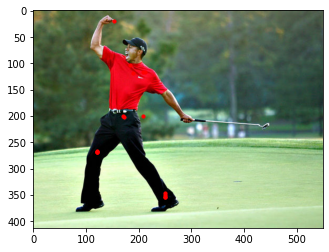

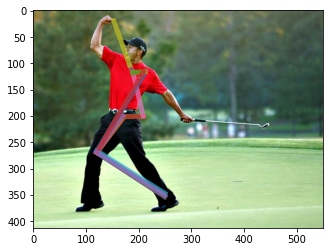

In [17]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

# STEP 1 : simplebaseline 모델 완성하기
- simplebaseline.py 파일과 이전에 살펴본 Simplebaseline 내용을 참고하여 모델을 완성

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

In [23]:
resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')

In [24]:
upconv1 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
bn1 = tf.keras.layers.BatchNormalization()
relu1 = tf.keras.layers.ReLU()
upconv2 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
bn2 = tf.keras.layers.BatchNormalization()
relu2 = tf.keras.layers.ReLU()
upconv3 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
bn3 = tf.keras.layers.BatchNormalization()
relu3 = tf.keras.layers.ReLU()

In [25]:
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

upconv = _make_deconv_layer(3)

In [26]:
final_layer = tf.keras.layers.Conv2D(17, kernel_size=(1,1), padding='same')

In [27]:
inputs = keras.Input(shape=(256, 192, 3))
x = resnet(inputs)
x = upconv(x)
out = final_layer(x)
model = keras.Model(inputs, out)

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 256, 192, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential_3 (Sequential)    (None, 64, 48, 256)       10489600  
_________________________________________________________________
conv2d_490 (Conv2D)          (None, 64, 48, 17)        4369      
Total params: 34,081,681
Trainable params: 34,027,025
Non-trainable params: 54,656
_________________________________________________________________


In [28]:
np_input = np.zeros((1,256,192,3), dtype=np.float32)
tf_input = tf.convert_to_tensor(np_input, dtype=tf.float32)
print('input shape')
print (tf_input.shape)
print('\n')

tf_output = model(tf_input)
print('output shape')
print (tf_output.shape)
print (tf_output[0,:10,:10,:10])

input shape
(1, 256, 192, 3)


output shape
(1, 64, 48, 17)
tf.Tensor(
[[[-9.82946483e-04  5.62750315e-03  3.37371370e-03 -1.04184705e-03
   -1.89725053e-03 -1.57634378e-03  7.18514086e-04 -8.00312497e-03
    1.78765145e-03  1.04947167e-03]
  [ 2.55473191e-03  1.51049718e-03  2.69551645e-03 -4.92469966e-03
   -2.26586573e-02 -1.17009534e-02  6.37806160e-03 -4.19945410e-03
    5.53305075e-03  2.93640140e-03]
  [-9.81669500e-03 -6.62156497e-04 -4.00581025e-03 -1.54855996e-02
   -1.44046899e-02  3.66487540e-04  8.09123181e-03 -2.10212339e-02
    7.15897325e-03 -4.21964470e-03]
  [-8.61802604e-03 -1.49600534e-03  7.44100474e-03 -1.26581844e-02
    2.74018408e-03 -2.31375708e-03  1.22875264e-02 -7.08583184e-03
   -4.04826133e-03  5.21731190e-03]
  [-4.63278405e-03  8.01894162e-03  1.43570798e-02 -7.83904456e-04
   -1.56979095e-02  6.96764234e-03  1.19651780e-02 -3.40816304e-02
    1.87750496e-02  1.26522630e-02]
  [-9.24124382e-03 -4.45658015e-03  8.89607612e-03 -6.76458795e-03
   -1.552438

# STEP 2 : simplebaseline 모델로 변경하여 훈련하기
- StackedHourglass를 학습시킨 코드의 모델 선언 부분을 simplebaseline 모델로 변경한 후 다시 학습을 진행

In [32]:

MODEL_PATH = os.path.expanduser('~/my_models')
saved_models = [f for f in os.listdir(MODEL_PATH) if f.endswith('.h5')]
print(" 저장된 모델 파일 목록:")
print(saved_models)

 저장된 모델 파일 목록:
['model-epoch-1-loss-1.4554.h5', 'model-epoch-3-loss-1.2615.h5', 'model-epoch-2-loss-1.3267.h5']


In [33]:
MODEL_PATH = os.path.expanduser('~/my_models/simplebaseline')
os.makedirs(MODEL_PATH, exist_ok=True)

--------------------------------------------------------------------------------------------

In [6]:

# Deconv 블록 정의
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4, 4), strides=(2, 2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

# SimpleBaseline 모델 정의
def Simplebaseline(input_shape=(256, 256, 3), num_heatmap=16):
    inputs = tf.keras.Input(shape=input_shape)
    
    resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    upconv = _make_deconv_layer(3)
    final_layer = tf.keras.layers.Conv2D(num_heatmap, kernel_size=(1, 1), padding='same')

    x = resnet(inputs)
    x = upconv(x)
    out = final_layer(x)

    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model

def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords, model_fn):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size

    # 데이터 생성 함수는 사용자 환경에 맞게 정의되어 있어야 함
    train_dataset = create_dataset(train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(val_dataset)

        model = model_fn(input_shape=(256, 256, 3), num_heatmap=num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate
        )

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)


In [7]:
# 하이퍼파라미터 설정
epochs = 3
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

# TFRecord 경로 설정
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')

# 학습 실행
best_SBL_file, SBL_history = train(
    epochs,
    learning_rate,
    num_heatmap,
    batch_size,
    train_tfrecords,
    val_tfrecords,
    Simplebaseline
)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 0.692859054 epoch total loss 0.692859054
Trained batch 2 batch loss 0.684366941 epoch total loss 0.688613
Trained batch 3 batch loss 0.579018533 epoch total loss 0.65208149
Trained batch 4 batch loss 0.49175036 epoch total loss 0.611998677
Trained batch 5 batch loss 0.487351477 epoch total loss 0.587069213
Trained batch 6 batch loss 0.452107191 epoch total loss 0.564575553
Trained batch 7 batch loss 0.445895851 epoch total loss 0.54762131
Trained batch 8 batch loss 0.450329661 epoch total loss 0.535459876
Trained batch 9 batch loss 0.442831814 epoch total loss 0.525167882
Trained batch 10 batch loss 0.432072282 epoch total loss 0.515858293
Trained batch 11 batch loss 0.392451942 epoch total loss 0.504639566
Trained batch 12 batch loss 0.429927111 epoch total loss 0.498413473
Trained batch 13 batch loss 0.452213705 epoch total loss 0.494859666
Trained batch 14 batch loss 0.436177224 epoch total loss 0.490668058
Trained batch 15 b

Trained batch 120 batch loss 0.351944268 epoch total loss 0.39857772
Trained batch 121 batch loss 0.324003965 epoch total loss 0.397961408
Trained batch 122 batch loss 0.344166517 epoch total loss 0.397520483
Trained batch 123 batch loss 0.329721 epoch total loss 0.396969259
Trained batch 124 batch loss 0.363666415 epoch total loss 0.39670068
Trained batch 125 batch loss 0.37712577 epoch total loss 0.396544069
Trained batch 126 batch loss 0.364185214 epoch total loss 0.396287262
Trained batch 127 batch loss 0.380441785 epoch total loss 0.39616251
Trained batch 128 batch loss 0.381447434 epoch total loss 0.396047533
Trained batch 129 batch loss 0.366767585 epoch total loss 0.395820558
Trained batch 130 batch loss 0.365935832 epoch total loss 0.395590693
Trained batch 131 batch loss 0.348700464 epoch total loss 0.395232737
Trained batch 132 batch loss 0.371101081 epoch total loss 0.39504993
Trained batch 133 batch loss 0.364681244 epoch total loss 0.394821584
Trained batch 134 batch loss

Trained batch 238 batch loss 0.382923245 epoch total loss 0.380964398
Trained batch 239 batch loss 0.378762543 epoch total loss 0.38095516
Trained batch 240 batch loss 0.368030638 epoch total loss 0.380901337
Trained batch 241 batch loss 0.359861165 epoch total loss 0.380814046
Trained batch 242 batch loss 0.372178733 epoch total loss 0.380778342
Trained batch 243 batch loss 0.384764224 epoch total loss 0.380794764
Trained batch 244 batch loss 0.360893309 epoch total loss 0.380713195
Trained batch 245 batch loss 0.33951664 epoch total loss 0.38054505
Trained batch 246 batch loss 0.367607713 epoch total loss 0.380492449
Trained batch 247 batch loss 0.364571571 epoch total loss 0.380428
Trained batch 248 batch loss 0.357446671 epoch total loss 0.380335301
Trained batch 249 batch loss 0.37195 epoch total loss 0.380301625
Trained batch 250 batch loss 0.383340716 epoch total loss 0.380313784
Trained batch 251 batch loss 0.393208563 epoch total loss 0.380365163
Trained batch 252 batch loss 0

Trained batch 356 batch loss 0.35648796 epoch total loss 0.370882303
Trained batch 357 batch loss 0.363426954 epoch total loss 0.370861441
Trained batch 358 batch loss 0.363497496 epoch total loss 0.370840877
Trained batch 359 batch loss 0.355051786 epoch total loss 0.370796919
Trained batch 360 batch loss 0.355598778 epoch total loss 0.370754719
Trained batch 361 batch loss 0.36773783 epoch total loss 0.370746344
Trained batch 362 batch loss 0.353553355 epoch total loss 0.370698839
Trained batch 363 batch loss 0.342054605 epoch total loss 0.370619923
Trained batch 364 batch loss 0.355801433 epoch total loss 0.370579213
Trained batch 365 batch loss 0.372681558 epoch total loss 0.370585
Trained batch 366 batch loss 0.318824 epoch total loss 0.370443553
Trained batch 367 batch loss 0.333791882 epoch total loss 0.370343655
Trained batch 368 batch loss 0.309829026 epoch total loss 0.370179206
Trained batch 369 batch loss 0.323310226 epoch total loss 0.370052189
Trained batch 370 batch loss

Trained batch 474 batch loss 0.325049192 epoch total loss 0.364111334
Trained batch 475 batch loss 0.31975624 epoch total loss 0.364017963
Trained batch 476 batch loss 0.354915023 epoch total loss 0.36399886
Trained batch 477 batch loss 0.31578207 epoch total loss 0.363897771
Trained batch 478 batch loss 0.28576991 epoch total loss 0.363734335
Trained batch 479 batch loss 0.331008196 epoch total loss 0.363666
Trained batch 480 batch loss 0.362205178 epoch total loss 0.363662928
Trained batch 481 batch loss 0.371218592 epoch total loss 0.363678634
Trained batch 482 batch loss 0.363503486 epoch total loss 0.363678306
Trained batch 483 batch loss 0.357841164 epoch total loss 0.363666207
Trained batch 484 batch loss 0.359769613 epoch total loss 0.36365816
Trained batch 485 batch loss 0.319549829 epoch total loss 0.363567203
Trained batch 486 batch loss 0.31714797 epoch total loss 0.363471717
Trained batch 487 batch loss 0.349330604 epoch total loss 0.363442659
Trained batch 488 batch loss 

Trained batch 592 batch loss 0.407179356 epoch total loss 0.358819127
Trained batch 593 batch loss 0.347587734 epoch total loss 0.358800203
Trained batch 594 batch loss 0.343193918 epoch total loss 0.358773947
Trained batch 595 batch loss 0.34259668 epoch total loss 0.358746737
Trained batch 596 batch loss 0.349317819 epoch total loss 0.358730942
Trained batch 597 batch loss 0.326376468 epoch total loss 0.358676732
Trained batch 598 batch loss 0.329207718 epoch total loss 0.358627439
Trained batch 599 batch loss 0.335917741 epoch total loss 0.35858953
Trained batch 600 batch loss 0.339538306 epoch total loss 0.358557791
Trained batch 601 batch loss 0.330887288 epoch total loss 0.358511746
Trained batch 602 batch loss 0.341418654 epoch total loss 0.358483344
Trained batch 603 batch loss 0.343532234 epoch total loss 0.358458549
Trained batch 604 batch loss 0.326933384 epoch total loss 0.358406365
Trained batch 605 batch loss 0.320841432 epoch total loss 0.358344287
Trained batch 606 batc

Trained batch 710 batch loss 0.337354839 epoch total loss 0.354913086
Trained batch 711 batch loss 0.330883861 epoch total loss 0.35487929
Trained batch 712 batch loss 0.298836231 epoch total loss 0.354800582
Trained batch 713 batch loss 0.294799089 epoch total loss 0.35471642
Trained batch 714 batch loss 0.294789046 epoch total loss 0.354632497
Trained batch 715 batch loss 0.302376211 epoch total loss 0.354559422
Trained batch 716 batch loss 0.323623627 epoch total loss 0.354516208
Trained batch 717 batch loss 0.324727952 epoch total loss 0.354474664
Trained batch 718 batch loss 0.346242934 epoch total loss 0.35446319
Trained batch 719 batch loss 0.340302318 epoch total loss 0.354443491
Trained batch 720 batch loss 0.336909294 epoch total loss 0.354419142
Trained batch 721 batch loss 0.332600981 epoch total loss 0.354388863
Trained batch 722 batch loss 0.352012128 epoch total loss 0.354385555
Trained batch 723 batch loss 0.333457083 epoch total loss 0.354356617
Trained batch 724 batch

Trained batch 828 batch loss 0.326824069 epoch total loss 0.351105362
Trained batch 829 batch loss 0.365326405 epoch total loss 0.351122528
Trained batch 830 batch loss 0.39019534 epoch total loss 0.351169586
Trained batch 831 batch loss 0.330079466 epoch total loss 0.351144224
Trained batch 832 batch loss 0.343980491 epoch total loss 0.351135612
Trained batch 833 batch loss 0.328411132 epoch total loss 0.351108313
Trained batch 834 batch loss 0.326962799 epoch total loss 0.351079375
Trained batch 835 batch loss 0.328854501 epoch total loss 0.351052761
Trained batch 836 batch loss 0.330687672 epoch total loss 0.351028413
Trained batch 837 batch loss 0.353750467 epoch total loss 0.351031661
Trained batch 838 batch loss 0.374766827 epoch total loss 0.351059973
Trained batch 839 batch loss 0.352058202 epoch total loss 0.351061165
Trained batch 840 batch loss 0.370137691 epoch total loss 0.351083875
Trained batch 841 batch loss 0.387380719 epoch total loss 0.351127058
Trained batch 842 bat

Trained batch 946 batch loss 0.361899048 epoch total loss 0.34786427
Trained batch 947 batch loss 0.323790282 epoch total loss 0.347838849
Trained batch 948 batch loss 0.322000742 epoch total loss 0.34781158
Trained batch 949 batch loss 0.33417061 epoch total loss 0.347797185
Trained batch 950 batch loss 0.283119768 epoch total loss 0.347729117
Trained batch 951 batch loss 0.321720719 epoch total loss 0.347701758
Trained batch 952 batch loss 0.342253029 epoch total loss 0.347696036
Trained batch 953 batch loss 0.337559819 epoch total loss 0.347685397
Trained batch 954 batch loss 0.326952964 epoch total loss 0.347663671
Trained batch 955 batch loss 0.308772415 epoch total loss 0.347622961
Trained batch 956 batch loss 0.305868 epoch total loss 0.3475793
Trained batch 957 batch loss 0.302355468 epoch total loss 0.347532034
Trained batch 958 batch loss 0.305787861 epoch total loss 0.347488463
Trained batch 959 batch loss 0.327616721 epoch total loss 0.347467721
Trained batch 960 batch loss

Trained batch 1063 batch loss 0.286996603 epoch total loss 0.344906092
Trained batch 1064 batch loss 0.268624872 epoch total loss 0.344834387
Trained batch 1065 batch loss 0.338203818 epoch total loss 0.344828159
Trained batch 1066 batch loss 0.340152502 epoch total loss 0.344823748
Trained batch 1067 batch loss 0.362255543 epoch total loss 0.34484008
Trained batch 1068 batch loss 0.323783606 epoch total loss 0.34482038
Trained batch 1069 batch loss 0.324607432 epoch total loss 0.344801486
Trained batch 1070 batch loss 0.359531134 epoch total loss 0.344815224
Trained batch 1071 batch loss 0.328568459 epoch total loss 0.344800085
Trained batch 1072 batch loss 0.339087158 epoch total loss 0.34479475
Trained batch 1073 batch loss 0.368661016 epoch total loss 0.344816983
Trained batch 1074 batch loss 0.336489737 epoch total loss 0.344809234
Trained batch 1075 batch loss 0.316895843 epoch total loss 0.344783247
Trained batch 1076 batch loss 0.314677685 epoch total loss 0.344755262
Trained b

Trained batch 1180 batch loss 0.334310085 epoch total loss 0.343107074
Trained batch 1181 batch loss 0.341229439 epoch total loss 0.343105495
Trained batch 1182 batch loss 0.351817608 epoch total loss 0.343112856
Trained batch 1183 batch loss 0.314235091 epoch total loss 0.343088448
Trained batch 1184 batch loss 0.288127244 epoch total loss 0.343042016
Trained batch 1185 batch loss 0.3109231 epoch total loss 0.343014896
Trained batch 1186 batch loss 0.31776005 epoch total loss 0.342993587
Trained batch 1187 batch loss 0.328074753 epoch total loss 0.342981
Trained batch 1188 batch loss 0.345288694 epoch total loss 0.342982948
Trained batch 1189 batch loss 0.312244743 epoch total loss 0.342957109
Trained batch 1190 batch loss 0.339474827 epoch total loss 0.342954189
Trained batch 1191 batch loss 0.275432646 epoch total loss 0.342897475
Trained batch 1192 batch loss 0.336939067 epoch total loss 0.342892498
Trained batch 1193 batch loss 0.342719495 epoch total loss 0.342892349
Trained batc

Trained batch 1296 batch loss 0.227675751 epoch total loss 0.34055078
Trained batch 1297 batch loss 0.303070962 epoch total loss 0.340521902
Trained batch 1298 batch loss 0.329642385 epoch total loss 0.340513527
Trained batch 1299 batch loss 0.376452953 epoch total loss 0.340541184
Trained batch 1300 batch loss 0.366930068 epoch total loss 0.340561509
Trained batch 1301 batch loss 0.348501623 epoch total loss 0.340567619
Trained batch 1302 batch loss 0.32183671 epoch total loss 0.340553224
Trained batch 1303 batch loss 0.325439274 epoch total loss 0.340541631
Trained batch 1304 batch loss 0.316354841 epoch total loss 0.340523064
Trained batch 1305 batch loss 0.320655733 epoch total loss 0.340507835
Trained batch 1306 batch loss 0.319837779 epoch total loss 0.340492
Trained batch 1307 batch loss 0.319891274 epoch total loss 0.340476245
Trained batch 1308 batch loss 0.323236763 epoch total loss 0.340463072
Trained batch 1309 batch loss 0.328518927 epoch total loss 0.340453953
Trained bat

Validated batch 40 batch loss 0.324637204
Validated batch 41 batch loss 0.334682405
Validated batch 42 batch loss 0.34253782
Validated batch 43 batch loss 0.383989871
Validated batch 44 batch loss 0.334046155
Validated batch 45 batch loss 0.319348902
Validated batch 46 batch loss 0.293878764
Validated batch 47 batch loss 0.332398355
Validated batch 48 batch loss 0.331809431
Validated batch 49 batch loss 0.315120757
Validated batch 50 batch loss 0.310524911
Validated batch 51 batch loss 0.329013675
Validated batch 52 batch loss 0.367839426
Validated batch 53 batch loss 0.30445835
Validated batch 54 batch loss 0.340146303
Validated batch 55 batch loss 0.336973608
Validated batch 56 batch loss 0.326238692
Validated batch 57 batch loss 0.324389607
Validated batch 58 batch loss 0.293284893
Validated batch 59 batch loss 0.358079255
Validated batch 60 batch loss 0.308458388
Validated batch 61 batch loss 0.334697634
Validated batch 62 batch loss 0.314650476
Validated batch 63 batch loss 0.3474

Trained batch 28 batch loss 0.309935868 epoch total loss 0.30557555
Trained batch 29 batch loss 0.301806033 epoch total loss 0.305445582
Trained batch 30 batch loss 0.279673845 epoch total loss 0.3045865
Trained batch 31 batch loss 0.270344198 epoch total loss 0.303481907
Trained batch 32 batch loss 0.262290597 epoch total loss 0.302194685
Trained batch 33 batch loss 0.307706743 epoch total loss 0.302361727
Trained batch 34 batch loss 0.302072555 epoch total loss 0.302353203
Trained batch 35 batch loss 0.322912395 epoch total loss 0.302940607
Trained batch 36 batch loss 0.315524936 epoch total loss 0.303290188
Trained batch 37 batch loss 0.311528981 epoch total loss 0.303512871
Trained batch 38 batch loss 0.266348 epoch total loss 0.302534819
Trained batch 39 batch loss 0.288560539 epoch total loss 0.302176535
Trained batch 40 batch loss 0.285410285 epoch total loss 0.301757365
Trained batch 41 batch loss 0.318564713 epoch total loss 0.302167296
Trained batch 42 batch loss 0.312477201 

Trained batch 147 batch loss 0.34036082 epoch total loss 0.310918063
Trained batch 148 batch loss 0.335937768 epoch total loss 0.311087132
Trained batch 149 batch loss 0.361467957 epoch total loss 0.311425269
Trained batch 150 batch loss 0.311486065 epoch total loss 0.311425656
Trained batch 151 batch loss 0.277480721 epoch total loss 0.311200857
Trained batch 152 batch loss 0.266230613 epoch total loss 0.310905
Trained batch 153 batch loss 0.277611494 epoch total loss 0.310687393
Trained batch 154 batch loss 0.277598202 epoch total loss 0.310472548
Trained batch 155 batch loss 0.28464818 epoch total loss 0.310305923
Trained batch 156 batch loss 0.302368551 epoch total loss 0.310255051
Trained batch 157 batch loss 0.309068054 epoch total loss 0.310247481
Trained batch 158 batch loss 0.324257165 epoch total loss 0.310336143
Trained batch 159 batch loss 0.331775725 epoch total loss 0.310471
Trained batch 160 batch loss 0.317383438 epoch total loss 0.310514182
Trained batch 161 batch loss

Trained batch 265 batch loss 0.259332746 epoch total loss 0.309180677
Trained batch 266 batch loss 0.298034817 epoch total loss 0.309138775
Trained batch 267 batch loss 0.319220603 epoch total loss 0.309176534
Trained batch 268 batch loss 0.376936 epoch total loss 0.309429377
Trained batch 269 batch loss 0.326830685 epoch total loss 0.309494048
Trained batch 270 batch loss 0.305016965 epoch total loss 0.309477448
Trained batch 271 batch loss 0.299190879 epoch total loss 0.30943951
Trained batch 272 batch loss 0.332476735 epoch total loss 0.309524208
Trained batch 273 batch loss 0.311845481 epoch total loss 0.309532702
Trained batch 274 batch loss 0.325207084 epoch total loss 0.309589922
Trained batch 275 batch loss 0.319390953 epoch total loss 0.309625536
Trained batch 276 batch loss 0.340902895 epoch total loss 0.309738874
Trained batch 277 batch loss 0.358784348 epoch total loss 0.30991596
Trained batch 278 batch loss 0.319269627 epoch total loss 0.309949577
Trained batch 279 batch l

Trained batch 383 batch loss 0.293603063 epoch total loss 0.309404552
Trained batch 384 batch loss 0.282652497 epoch total loss 0.309334874
Trained batch 385 batch loss 0.30938977 epoch total loss 0.309335023
Trained batch 386 batch loss 0.308309019 epoch total loss 0.309332371
Trained batch 387 batch loss 0.315301716 epoch total loss 0.309347779
Trained batch 388 batch loss 0.306632072 epoch total loss 0.309340775
Trained batch 389 batch loss 0.29614079 epoch total loss 0.30930686
Trained batch 390 batch loss 0.282636642 epoch total loss 0.309238464
Trained batch 391 batch loss 0.300868154 epoch total loss 0.309217066
Trained batch 392 batch loss 0.289963841 epoch total loss 0.309167951
Trained batch 393 batch loss 0.32999897 epoch total loss 0.30922094
Trained batch 394 batch loss 0.32635662 epoch total loss 0.309264451
Trained batch 395 batch loss 0.328773618 epoch total loss 0.309313834
Trained batch 396 batch loss 0.308650464 epoch total loss 0.309312135
Trained batch 397 batch lo

Trained batch 501 batch loss 0.33028385 epoch total loss 0.309522
Trained batch 502 batch loss 0.287714899 epoch total loss 0.309478581
Trained batch 503 batch loss 0.309038669 epoch total loss 0.309477687
Trained batch 504 batch loss 0.321064293 epoch total loss 0.309500664
Trained batch 505 batch loss 0.304646939 epoch total loss 0.309491068
Trained batch 506 batch loss 0.296785176 epoch total loss 0.309465945
Trained batch 507 batch loss 0.32407552 epoch total loss 0.309494764
Trained batch 508 batch loss 0.309317231 epoch total loss 0.309494406
Trained batch 509 batch loss 0.302293897 epoch total loss 0.30948025
Trained batch 510 batch loss 0.308502764 epoch total loss 0.309478343
Trained batch 511 batch loss 0.257854104 epoch total loss 0.309377313
Trained batch 512 batch loss 0.275489926 epoch total loss 0.309311152
Trained batch 513 batch loss 0.330811381 epoch total loss 0.309353054
Trained batch 514 batch loss 0.341876984 epoch total loss 0.309416324
Trained batch 515 batch lo

Trained batch 619 batch loss 0.25327456 epoch total loss 0.309262216
Trained batch 620 batch loss 0.314273417 epoch total loss 0.309270293
Trained batch 621 batch loss 0.323609412 epoch total loss 0.309293389
Trained batch 622 batch loss 0.308603466 epoch total loss 0.309292287
Trained batch 623 batch loss 0.304309666 epoch total loss 0.3092843
Trained batch 624 batch loss 0.301862836 epoch total loss 0.309272408
Trained batch 625 batch loss 0.31094265 epoch total loss 0.309275061
Trained batch 626 batch loss 0.300925732 epoch total loss 0.309261709
Trained batch 627 batch loss 0.291502684 epoch total loss 0.309233397
Trained batch 628 batch loss 0.324946642 epoch total loss 0.309258431
Trained batch 629 batch loss 0.317514688 epoch total loss 0.309271574
Trained batch 630 batch loss 0.302013457 epoch total loss 0.309260041
Trained batch 631 batch loss 0.283800304 epoch total loss 0.309219688
Trained batch 632 batch loss 0.298175931 epoch total loss 0.309202224
Trained batch 633 batch 

Trained batch 737 batch loss 0.32199508 epoch total loss 0.309456378
Trained batch 738 batch loss 0.368852317 epoch total loss 0.309536844
Trained batch 739 batch loss 0.351420343 epoch total loss 0.309593529
Trained batch 740 batch loss 0.314216286 epoch total loss 0.309599787
Trained batch 741 batch loss 0.341380954 epoch total loss 0.309642673
Trained batch 742 batch loss 0.332233489 epoch total loss 0.309673101
Trained batch 743 batch loss 0.347346395 epoch total loss 0.309723824
Trained batch 744 batch loss 0.300055385 epoch total loss 0.30971083
Trained batch 745 batch loss 0.285776883 epoch total loss 0.309678704
Trained batch 746 batch loss 0.300279647 epoch total loss 0.309666097
Trained batch 747 batch loss 0.30762428 epoch total loss 0.309663355
Trained batch 748 batch loss 0.322725773 epoch total loss 0.30968082
Trained batch 749 batch loss 0.319186538 epoch total loss 0.309693515
Trained batch 750 batch loss 0.339532614 epoch total loss 0.309733301
Trained batch 751 batch 

Trained batch 855 batch loss 0.325322151 epoch total loss 0.308963746
Trained batch 856 batch loss 0.29126215 epoch total loss 0.308943063
Trained batch 857 batch loss 0.299325973 epoch total loss 0.308931828
Trained batch 858 batch loss 0.278205335 epoch total loss 0.308896
Trained batch 859 batch loss 0.272130817 epoch total loss 0.308853209
Trained batch 860 batch loss 0.300180852 epoch total loss 0.308843106
Trained batch 861 batch loss 0.325697958 epoch total loss 0.308862656
Trained batch 862 batch loss 0.333936721 epoch total loss 0.308891743
Trained batch 863 batch loss 0.309346378 epoch total loss 0.30889228
Trained batch 864 batch loss 0.300635904 epoch total loss 0.308882713
Trained batch 865 batch loss 0.304039538 epoch total loss 0.30887711
Trained batch 866 batch loss 0.297899574 epoch total loss 0.308864474
Trained batch 867 batch loss 0.253240049 epoch total loss 0.30880031
Trained batch 868 batch loss 0.297431111 epoch total loss 0.308787197
Trained batch 869 batch los

Trained batch 973 batch loss 0.346610218 epoch total loss 0.308392853
Trained batch 974 batch loss 0.331932336 epoch total loss 0.308417022
Trained batch 975 batch loss 0.310070872 epoch total loss 0.308418721
Trained batch 976 batch loss 0.295294583 epoch total loss 0.30840528
Trained batch 977 batch loss 0.301261514 epoch total loss 0.308397949
Trained batch 978 batch loss 0.315983176 epoch total loss 0.308405727
Trained batch 979 batch loss 0.337777078 epoch total loss 0.308435708
Trained batch 980 batch loss 0.338779598 epoch total loss 0.308466673
Trained batch 981 batch loss 0.315940112 epoch total loss 0.308474302
Trained batch 982 batch loss 0.312539637 epoch total loss 0.308478415
Trained batch 983 batch loss 0.325602353 epoch total loss 0.30849582
Trained batch 984 batch loss 0.306690216 epoch total loss 0.308494
Trained batch 985 batch loss 0.303903 epoch total loss 0.308489352
Trained batch 986 batch loss 0.286613643 epoch total loss 0.30846715
Trained batch 987 batch loss 

Trained batch 1090 batch loss 0.312293261 epoch total loss 0.308260202
Trained batch 1091 batch loss 0.319022894 epoch total loss 0.308270097
Trained batch 1092 batch loss 0.306786716 epoch total loss 0.308268726
Trained batch 1093 batch loss 0.339152038 epoch total loss 0.308296978
Trained batch 1094 batch loss 0.29770714 epoch total loss 0.308287293
Trained batch 1095 batch loss 0.318027079 epoch total loss 0.308296174
Trained batch 1096 batch loss 0.322138041 epoch total loss 0.30830881
Trained batch 1097 batch loss 0.327184141 epoch total loss 0.308326
Trained batch 1098 batch loss 0.304382414 epoch total loss 0.30832243
Trained batch 1099 batch loss 0.305008709 epoch total loss 0.30831942
Trained batch 1100 batch loss 0.277073205 epoch total loss 0.308291018
Trained batch 1101 batch loss 0.267047495 epoch total loss 0.308253556
Trained batch 1102 batch loss 0.294257134 epoch total loss 0.308240861
Trained batch 1103 batch loss 0.289212406 epoch total loss 0.308223605
Trained batch

Trained batch 1207 batch loss 0.26199308 epoch total loss 0.308070749
Trained batch 1208 batch loss 0.317572445 epoch total loss 0.308078617
Trained batch 1209 batch loss 0.320851892 epoch total loss 0.308089197
Trained batch 1210 batch loss 0.28583467 epoch total loss 0.308070779
Trained batch 1211 batch loss 0.333408922 epoch total loss 0.3080917
Trained batch 1212 batch loss 0.301125377 epoch total loss 0.308085948
Trained batch 1213 batch loss 0.263851464 epoch total loss 0.3080495
Trained batch 1214 batch loss 0.305499792 epoch total loss 0.308047414
Trained batch 1215 batch loss 0.299372524 epoch total loss 0.308040261
Trained batch 1216 batch loss 0.332780123 epoch total loss 0.308060616
Trained batch 1217 batch loss 0.335367739 epoch total loss 0.308083057
Trained batch 1218 batch loss 0.33315748 epoch total loss 0.308103651
Trained batch 1219 batch loss 0.341142505 epoch total loss 0.308130741
Trained batch 1220 batch loss 0.340961933 epoch total loss 0.308157682
Trained batch

Trained batch 1324 batch loss 0.282821417 epoch total loss 0.307896972
Trained batch 1325 batch loss 0.294662535 epoch total loss 0.307887018
Trained batch 1326 batch loss 0.278839111 epoch total loss 0.307865113
Trained batch 1327 batch loss 0.285503924 epoch total loss 0.307848245
Trained batch 1328 batch loss 0.30049473 epoch total loss 0.307842702
Trained batch 1329 batch loss 0.331896096 epoch total loss 0.307860821
Trained batch 1330 batch loss 0.329330564 epoch total loss 0.307876974
Trained batch 1331 batch loss 0.307937562 epoch total loss 0.307877
Trained batch 1332 batch loss 0.348560572 epoch total loss 0.307907552
Trained batch 1333 batch loss 0.322906494 epoch total loss 0.307918817
Trained batch 1334 batch loss 0.340239644 epoch total loss 0.307943046
Trained batch 1335 batch loss 0.308243454 epoch total loss 0.307943285
Trained batch 1336 batch loss 0.313007355 epoch total loss 0.307947069
Trained batch 1337 batch loss 0.303960979 epoch total loss 0.307944089
Trained ba

Validated batch 87 batch loss 0.310610443
Validated batch 88 batch loss 0.32443589
Validated batch 89 batch loss 0.361184895
Validated batch 90 batch loss 0.332330048
Validated batch 91 batch loss 0.311237037
Validated batch 92 batch loss 0.283073872
Validated batch 93 batch loss 0.283891708
Validated batch 94 batch loss 0.274271727
Validated batch 95 batch loss 0.311754525
Validated batch 96 batch loss 0.291407794
Validated batch 97 batch loss 0.303815246
Validated batch 98 batch loss 0.314034879
Validated batch 99 batch loss 0.312277436
Validated batch 100 batch loss 0.308686316
Validated batch 101 batch loss 0.303889602
Validated batch 102 batch loss 0.296508402
Validated batch 103 batch loss 0.330367923
Validated batch 104 batch loss 0.310264349
Validated batch 105 batch loss 0.294065893
Validated batch 106 batch loss 0.307130784
Validated batch 107 batch loss 0.315739065
Validated batch 108 batch loss 0.291744053
Validated batch 109 batch loss 0.337781787
Validated batch 110 batch

Trained batch 57 batch loss 0.27790755 epoch total loss 0.30144763
Trained batch 58 batch loss 0.276614189 epoch total loss 0.30101946
Trained batch 59 batch loss 0.257330835 epoch total loss 0.300278962
Trained batch 60 batch loss 0.26957956 epoch total loss 0.299767315
Trained batch 61 batch loss 0.291122645 epoch total loss 0.299625576
Trained batch 62 batch loss 0.301425248 epoch total loss 0.299654633
Trained batch 63 batch loss 0.30165863 epoch total loss 0.299686432
Trained batch 64 batch loss 0.301892877 epoch total loss 0.299720913
Trained batch 65 batch loss 0.314457387 epoch total loss 0.299947619
Trained batch 66 batch loss 0.334008306 epoch total loss 0.300463706
Trained batch 67 batch loss 0.310209453 epoch total loss 0.300609171
Trained batch 68 batch loss 0.314502478 epoch total loss 0.300813466
Trained batch 69 batch loss 0.291959226 epoch total loss 0.300685167
Trained batch 70 batch loss 0.264681309 epoch total loss 0.300170809
Trained batch 71 batch loss 0.285226375

Trained batch 176 batch loss 0.318313539 epoch total loss 0.296914607
Trained batch 177 batch loss 0.31227845 epoch total loss 0.297001392
Trained batch 178 batch loss 0.326464027 epoch total loss 0.297166944
Trained batch 179 batch loss 0.305774152 epoch total loss 0.297215
Trained batch 180 batch loss 0.30978474 epoch total loss 0.297284842
Trained batch 181 batch loss 0.302337438 epoch total loss 0.297312766
Trained batch 182 batch loss 0.273027539 epoch total loss 0.297179341
Trained batch 183 batch loss 0.288656473 epoch total loss 0.29713276
Trained batch 184 batch loss 0.29559198 epoch total loss 0.297124416
Trained batch 185 batch loss 0.287458479 epoch total loss 0.297072172
Trained batch 186 batch loss 0.297286391 epoch total loss 0.297073334
Trained batch 187 batch loss 0.328099251 epoch total loss 0.297239244
Trained batch 188 batch loss 0.298643649 epoch total loss 0.297246724
Trained batch 189 batch loss 0.333082139 epoch total loss 0.297436297
Trained batch 190 batch los

Trained batch 294 batch loss 0.31129685 epoch total loss 0.298283219
Trained batch 295 batch loss 0.290578961 epoch total loss 0.298257113
Trained batch 296 batch loss 0.324216783 epoch total loss 0.298344821
Trained batch 297 batch loss 0.300825953 epoch total loss 0.298353165
Trained batch 298 batch loss 0.258690059 epoch total loss 0.298220068
Trained batch 299 batch loss 0.253411114 epoch total loss 0.298070222
Trained batch 300 batch loss 0.26335451 epoch total loss 0.29795447
Trained batch 301 batch loss 0.284363508 epoch total loss 0.297909319
Trained batch 302 batch loss 0.319429636 epoch total loss 0.297980577
Trained batch 303 batch loss 0.296626 epoch total loss 0.297976106
Trained batch 304 batch loss 0.2776438 epoch total loss 0.2979092
Trained batch 305 batch loss 0.299036503 epoch total loss 0.297912896
Trained batch 306 batch loss 0.310830474 epoch total loss 0.297955096
Trained batch 307 batch loss 0.313011408 epoch total loss 0.29800415
Trained batch 308 batch loss 0.

Trained batch 412 batch loss 0.267949969 epoch total loss 0.29779917
Trained batch 413 batch loss 0.277960628 epoch total loss 0.297751129
Trained batch 414 batch loss 0.296129674 epoch total loss 0.297747195
Trained batch 415 batch loss 0.277171373 epoch total loss 0.297697604
Trained batch 416 batch loss 0.304339796 epoch total loss 0.297713578
Trained batch 417 batch loss 0.295744151 epoch total loss 0.297708869
Trained batch 418 batch loss 0.323111773 epoch total loss 0.297769636
Trained batch 419 batch loss 0.298574835 epoch total loss 0.297771543
Trained batch 420 batch loss 0.304526061 epoch total loss 0.297787637
Trained batch 421 batch loss 0.314042568 epoch total loss 0.29782626
Trained batch 422 batch loss 0.324087918 epoch total loss 0.297888488
Trained batch 423 batch loss 0.31469515 epoch total loss 0.297928214
Trained batch 424 batch loss 0.281788588 epoch total loss 0.297890157
Trained batch 425 batch loss 0.287394226 epoch total loss 0.29786545
Trained batch 426 batch 

Trained batch 530 batch loss 0.283772796 epoch total loss 0.296842963
Trained batch 531 batch loss 0.309078336 epoch total loss 0.296866
Trained batch 532 batch loss 0.29665482 epoch total loss 0.296865612
Trained batch 533 batch loss 0.331424057 epoch total loss 0.296930462
Trained batch 534 batch loss 0.292540103 epoch total loss 0.296922237
Trained batch 535 batch loss 0.315352648 epoch total loss 0.296956688
Trained batch 536 batch loss 0.290425181 epoch total loss 0.296944499
Trained batch 537 batch loss 0.291441411 epoch total loss 0.296934247
Trained batch 538 batch loss 0.303568572 epoch total loss 0.296946585
Trained batch 539 batch loss 0.273122311 epoch total loss 0.296902388
Trained batch 540 batch loss 0.295898736 epoch total loss 0.296900511
Trained batch 541 batch loss 0.271897584 epoch total loss 0.296854287
Trained batch 542 batch loss 0.315480858 epoch total loss 0.296888649
Trained batch 543 batch loss 0.274375141 epoch total loss 0.296847194
Trained batch 544 batch 

Trained batch 648 batch loss 0.291650683 epoch total loss 0.295863032
Trained batch 649 batch loss 0.30736208 epoch total loss 0.295880765
Trained batch 650 batch loss 0.260293275 epoch total loss 0.295826018
Trained batch 651 batch loss 0.332232684 epoch total loss 0.295881927
Trained batch 652 batch loss 0.323134035 epoch total loss 0.29592374
Trained batch 653 batch loss 0.303577363 epoch total loss 0.295935452
Trained batch 654 batch loss 0.258456826 epoch total loss 0.295878142
Trained batch 655 batch loss 0.289913535 epoch total loss 0.295869052
Trained batch 656 batch loss 0.274900079 epoch total loss 0.295837075
Trained batch 657 batch loss 0.279131323 epoch total loss 0.295811653
Trained batch 658 batch loss 0.279679 epoch total loss 0.295787126
Trained batch 659 batch loss 0.28963691 epoch total loss 0.295777798
Trained batch 660 batch loss 0.3172234 epoch total loss 0.295810312
Trained batch 661 batch loss 0.258020252 epoch total loss 0.295753151
Trained batch 662 batch loss

Trained batch 766 batch loss 0.280454814 epoch total loss 0.29642579
Trained batch 767 batch loss 0.274549484 epoch total loss 0.296397269
Trained batch 768 batch loss 0.294777125 epoch total loss 0.296395153
Trained batch 769 batch loss 0.299293101 epoch total loss 0.296398908
Trained batch 770 batch loss 0.308024824 epoch total loss 0.296414018
Trained batch 771 batch loss 0.286435604 epoch total loss 0.296401083
Trained batch 772 batch loss 0.279852092 epoch total loss 0.296379656
Trained batch 773 batch loss 0.281385064 epoch total loss 0.296360254
Trained batch 774 batch loss 0.299123675 epoch total loss 0.296363801
Trained batch 775 batch loss 0.315338 epoch total loss 0.296388298
Trained batch 776 batch loss 0.29103598 epoch total loss 0.296381384
Trained batch 777 batch loss 0.284756035 epoch total loss 0.296366423
Trained batch 778 batch loss 0.304790735 epoch total loss 0.296377271
Trained batch 779 batch loss 0.292897612 epoch total loss 0.296372801
Trained batch 780 batch l

Trained batch 884 batch loss 0.303261459 epoch total loss 0.2962448
Trained batch 885 batch loss 0.283317983 epoch total loss 0.296230197
Trained batch 886 batch loss 0.265230179 epoch total loss 0.296195209
Trained batch 887 batch loss 0.276901484 epoch total loss 0.296173483
Trained batch 888 batch loss 0.277562976 epoch total loss 0.296152502
Trained batch 889 batch loss 0.291397125 epoch total loss 0.296147168
Trained batch 890 batch loss 0.276851714 epoch total loss 0.296125501
Trained batch 891 batch loss 0.288742572 epoch total loss 0.296117246
Trained batch 892 batch loss 0.275881201 epoch total loss 0.296094537
Trained batch 893 batch loss 0.30243504 epoch total loss 0.29610163
Trained batch 894 batch loss 0.323145419 epoch total loss 0.296131879
Trained batch 895 batch loss 0.301428884 epoch total loss 0.29613781
Trained batch 896 batch loss 0.272477865 epoch total loss 0.296111405
Trained batch 897 batch loss 0.277187079 epoch total loss 0.296090335
Trained batch 898 batch l

Trained batch 1002 batch loss 0.282455713 epoch total loss 0.295069814
Trained batch 1003 batch loss 0.301365197 epoch total loss 0.295076072
Trained batch 1004 batch loss 0.324843347 epoch total loss 0.295105696
Trained batch 1005 batch loss 0.297060758 epoch total loss 0.295107663
Trained batch 1006 batch loss 0.322040677 epoch total loss 0.295134425
Trained batch 1007 batch loss 0.304974228 epoch total loss 0.2951442
Trained batch 1008 batch loss 0.310174674 epoch total loss 0.295159101
Trained batch 1009 batch loss 0.280947864 epoch total loss 0.295145035
Trained batch 1010 batch loss 0.297490239 epoch total loss 0.29514733
Trained batch 1011 batch loss 0.316609383 epoch total loss 0.295168579
Trained batch 1012 batch loss 0.31999132 epoch total loss 0.295193106
Trained batch 1013 batch loss 0.289706022 epoch total loss 0.295187682
Trained batch 1014 batch loss 0.293524861 epoch total loss 0.295186043
Trained batch 1015 batch loss 0.325156748 epoch total loss 0.295215577
Trained ba

Trained batch 1119 batch loss 0.276531 epoch total loss 0.294642299
Trained batch 1120 batch loss 0.30542171 epoch total loss 0.294651926
Trained batch 1121 batch loss 0.31692782 epoch total loss 0.294671804
Trained batch 1122 batch loss 0.32840234 epoch total loss 0.294701874
Trained batch 1123 batch loss 0.289632976 epoch total loss 0.294697344
Trained batch 1124 batch loss 0.299653709 epoch total loss 0.294701755
Trained batch 1125 batch loss 0.293710768 epoch total loss 0.294700861
Trained batch 1126 batch loss 0.303300053 epoch total loss 0.29470852
Trained batch 1127 batch loss 0.26204896 epoch total loss 0.294679552
Trained batch 1128 batch loss 0.284755737 epoch total loss 0.294670761
Trained batch 1129 batch loss 0.306214154 epoch total loss 0.294680983
Trained batch 1130 batch loss 0.297633201 epoch total loss 0.294683605
Trained batch 1131 batch loss 0.277585 epoch total loss 0.294668466
Trained batch 1132 batch loss 0.318110615 epoch total loss 0.294689178
Trained batch 113

Trained batch 1235 batch loss 0.310675979 epoch total loss 0.294946641
Trained batch 1236 batch loss 0.297196418 epoch total loss 0.294948459
Trained batch 1237 batch loss 0.316265523 epoch total loss 0.294965684
Trained batch 1238 batch loss 0.307842523 epoch total loss 0.294976085
Trained batch 1239 batch loss 0.293897957 epoch total loss 0.294975191
Trained batch 1240 batch loss 0.283862442 epoch total loss 0.294966251
Trained batch 1241 batch loss 0.268622071 epoch total loss 0.294945
Trained batch 1242 batch loss 0.269293249 epoch total loss 0.294924349
Trained batch 1243 batch loss 0.280273646 epoch total loss 0.294912577
Trained batch 1244 batch loss 0.276822031 epoch total loss 0.294898033
Trained batch 1245 batch loss 0.281994075 epoch total loss 0.294887662
Trained batch 1246 batch loss 0.270600557 epoch total loss 0.294868171
Trained batch 1247 batch loss 0.261014223 epoch total loss 0.294841021
Trained batch 1248 batch loss 0.270917356 epoch total loss 0.294821829
Trained b

Trained batch 1351 batch loss 0.297004312 epoch total loss 0.294909149
Trained batch 1352 batch loss 0.334283859 epoch total loss 0.294938296
Trained batch 1353 batch loss 0.319491565 epoch total loss 0.294956416
Trained batch 1354 batch loss 0.287013918 epoch total loss 0.294950575
Trained batch 1355 batch loss 0.264624834 epoch total loss 0.294928193
Trained batch 1356 batch loss 0.238241255 epoch total loss 0.29488638
Trained batch 1357 batch loss 0.26925084 epoch total loss 0.294867486
Trained batch 1358 batch loss 0.247992396 epoch total loss 0.294832975
Trained batch 1359 batch loss 0.254644662 epoch total loss 0.294803411
Trained batch 1360 batch loss 0.273271 epoch total loss 0.294787586
Trained batch 1361 batch loss 0.283185333 epoch total loss 0.294779032
Trained batch 1362 batch loss 0.269422293 epoch total loss 0.294760406
Trained batch 1363 batch loss 0.269666553 epoch total loss 0.294742
Trained batch 1364 batch loss 0.313904852 epoch total loss 0.294756055
Trained batch 

Validated batch 132 batch loss 0.299520493
Validated batch 133 batch loss 0.339189798
Validated batch 134 batch loss 0.289586931
Validated batch 135 batch loss 0.323341429
Validated batch 136 batch loss 0.306997478
Validated batch 137 batch loss 0.241669044
Validated batch 138 batch loss 0.297034621
Validated batch 139 batch loss 0.300621539
Validated batch 140 batch loss 0.315459549
Validated batch 141 batch loss 0.311173469
Validated batch 142 batch loss 0.271047741
Validated batch 143 batch loss 0.317030251
Validated batch 144 batch loss 0.308130801
Validated batch 145 batch loss 0.330278039
Validated batch 146 batch loss 0.333707452
Validated batch 147 batch loss 0.304783046
Validated batch 148 batch loss 0.296089381
Validated batch 149 batch loss 0.311847925
Validated batch 150 batch loss 0.314046741
Validated batch 151 batch loss 0.2986435
Validated batch 152 batch loss 0.323954701
Validated batch 153 batch loss 0.333749533
Validated batch 154 batch loss 0.300965667
Validated bat

ValueError: too many values to unpack (expected 2)

In [22]:
# 1. 모델 구조 정의 (학습할 때랑 똑같이!)
simplebaseline_model = Simplebaseline(input_shape=(256, 192, 3), num_heatmap=16)

# 2. 저장된 가중치 불러오기
simplebaseline_model_path = os.path.expanduser('~/my_models/model-epoch-3-loss-0.3013.h5')
simplebaseline_model.load_weights(simplebaseline_model_path)

# 1. StackedHourglass 모델 구조 정의 
StackedHourglassNetwork_model = StackedHourglassNetwork(input_shape=(256, 256, 3), num_stack=4, num_residual=1, num_heatmap=16)

# 2. 가중치 불러오기
StackedHourglassNetwork_model_path = os.path.expanduser('~/my_models/model-epoch-3-loss-1.2615.h5')
StackedHourglassNetwork_model.load_weights(StackedHourglassNetwork_model_path)


# STEP 3 : 두 모델의 비교
### StackedHourglass Network와 Simplebaseline 모델을 둘 다 동일한 Epoch 수만큼 학습하여 그 결과를 비교
- Pose Estimation 결과 시각화 (정성적 비교)
- 학습 진행 경과 (loss 감소 현황)
- 가급적 두 모델 모두 최소 3epoch 이상, (5epoch 이상 권장)을 학습하기 바랍니다.

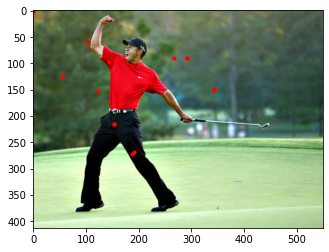

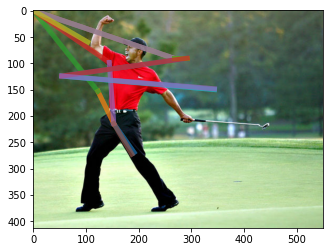

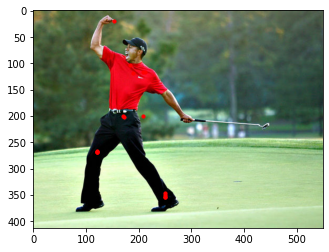

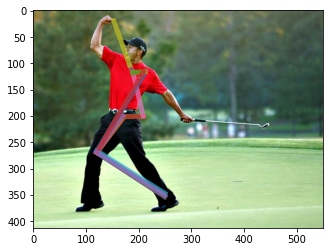

In [26]:
test_image_path = os.path.join(PROJECT_PATH, 'test_image.jpg')

#  SimpleBaseline 예측 
sb_image, sb_keypoints = predict(simplebaseline_model, test_image_path, input_size=(256, 192))
draw_keypoints_on_image(sb_image, sb_keypoints)
draw_skeleton_on_image(sb_image, sb_keypoints)

#  StackedHourglass 예측 
hg_image, hg_keypoints = predict(StackedHourglassNetwork_model, test_image_path, input_size=(256, 256))
draw_keypoints_on_image(hg_image, hg_keypoints)
draw_skeleton_on_image(hg_image, hg_keypoints)


In [39]:
def compute_pck(pred_keypoints, gt_keypoints, threshold=0.05, image_size=256):
    pred_keypoints = np.array(pred_keypoints)
    gt_keypoints = np.array(gt_keypoints)
    assert pred_keypoints.shape == gt_keypoints.shape, "shape mismatch!"

    correct = 0
    total = len(pred_keypoints)
    for pred, gt in zip(pred_keypoints, gt_keypoints):
        dist = np.linalg.norm((pred - gt) * image_size)
        if dist < threshold * image_size:
            correct += 1
    return correct / total
gt_keypoints = load_ground_truth_keypoints('test_image.jpg')  # 정규화된 (0~1) 좌표라고 가정

sb_pck = compute_pck(sb_keypoints, gt_keypoints)
hg_pck = compute_pck(hg_keypoints, gt_keypoints)

print(f" SimpleBaseline PCK: {sb_pck:.2f}")
print(f" StackedHourglass PCK: {hg_pck:.2f}")


NameError: name 'load_ground_truth_keypoints' is not defined

- 정답 keypoints (GT) 값을 모르겠음
- 정답 keypoints (GT) 랜덤으로 생성...?


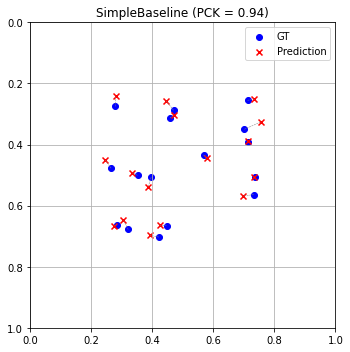

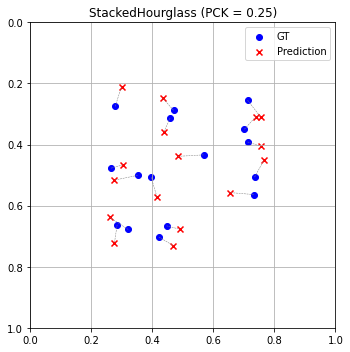

In [34]:

# 1. GT 및 예측 시뮬레이션
gt_keypoints = np.random.rand(16, 2) * 0.5 + 0.25  # 중심 근처
sb_keypoints = gt_keypoints + (np.random.randn(16, 2) * 0.02)
hg_keypoints = gt_keypoints + (np.random.randn(16, 2) * 0.05)

# 2. PCK 계산 함수
def compute_pck(pred_keypoints, gt_keypoints, threshold=0.05, image_size=256):
    N, K, _ = pred_keypoints.shape
    correct = 0
    for i in range(N):
        for j in range(K):
            pred = pred_keypoints[i][j]
            gt = gt_keypoints[i][j]
            dist = np.linalg.norm(pred - gt)
            if dist < threshold * 1.0:
                correct += 1
    return correct / (N * K)

# 3. 시각화 함수
def draw_keypoints_overlay(gt, pred, title):
    plt.figure(figsize=(5, 5))
    plt.xlim(0, 1)
    plt.ylim(1, 0)
    plt.gca().set_aspect('equal')
    plt.title(title)
    plt.scatter(gt[:, 0], gt[:, 1], c='blue', label='GT')
    plt.scatter(pred[:, 0], pred[:, 1], c='red', marker='x', label='Prediction')
    for i in range(len(gt)):
        plt.plot([gt[i][0], pred[i][0]], [gt[i][1], pred[i][1]], 'gray', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

# 4. 확장 및 평가
sb_preds = np.expand_dims(sb_keypoints, axis=0)
hg_preds = np.expand_dims(hg_keypoints, axis=0)
gt_exp = np.expand_dims(gt_keypoints, axis=0)
sb_pck = compute_pck(sb_preds, gt_exp)
hg_pck = compute_pck(hg_preds, gt_exp)

# 5. 시각화
draw_keypoints_overlay(gt_keypoints, sb_keypoints, f"SimpleBaseline (PCK = {sb_pck:.2f})")
draw_keypoints_overlay(gt_keypoints, hg_keypoints, f"StackedHourglass (PCK = {hg_pck:.2f})")
plt.show()


# 회고
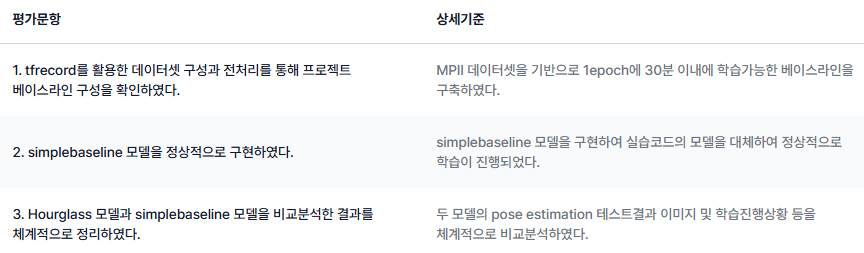


1. TFRecord를 활용한 데이터셋 구성과 프로젝트 베이스라인 구축

- MPII 데이터셋을 기반으로 tfrecord 포맷으로 데이터를 구성하고, 이를 통해 효율적인 학습 파이프라인을 구현


2. SimpleBaseline 모델을 정상적으로 구현하였다

- 실습 코드를 참고하여 `SimpleBaseline` 모델을 구현하고 학습까지 완료하였다.
- `ResNet50` 백본을 사용한 후, Conv2DTranspose와 Conv2D로 heatmap을 출력하는 구조로 구성되어 상대적으로 단순하면서도 효과적인 방식임을 확인하였다.

3. Hourglass vs SimpleBaseline 비교 분석

- 동일한 조건에서 `Stacked Hourglass` 모델과 `SimpleBaseline` 모델을 각각 학습시킨 뒤, 테스트 이미지에 대해 예측 결과를 시각화
- 두 모델의 keypoint 예측 정확도를 `PCK` 기준으로 정량 평가하였고, SimpleBaseline 모델이 유사하거나 더 높은 성능을 보였다.
- 특히 이 프로젝트 범위 내에서는 `Hourglass` 모델의 복잡한 구조만큼의 정밀한 학습은 필요하지 않았으며,
  **SimpleBaseline 모델이 더 간단한 구조임에도 불구하고 충분한 성능을 보였다는 점에서 더 효과적인 선택이었다.**

## 결론

- 포즈 추정 모델을 구현하고 비교해보면서, 복잡한 모델이 항상 더 나은 결과를 내지는 않는다는 점을 체감할 수 있었다.
- 실전에서는 과제의 범위, 연산 자원, 구현 난이도 등을 고려하여 적절한 구조를 선택하는 것이 중요할 것 같다
